In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

from sklearn.inspection import partial_dependence

import source.utility as ut
import source.transf_univ as df_p
import source.report as rp
from source.validate import random_split, yearly_split
from source.events_plot import plot_game

pd.set_option("max_columns", 300)

kfolds = KFold(n_splits=5, shuffle=True, random_state=345)

# Processing

* differences
* sums
* percentages
* cleaning

3 sets:
* full
* Only not used stuff
* Personal selection

In [2]:
def make_feats(data):
    df = data.copy()
    
    for col in [col for col in df if 'W' in col and ('_half2' in col or '_crunchtime' in col)]:
        name = col.replace('W', '')
        df[name+'_diff'] = df['W' + name] - df['L' + name]
        
    for col in ['FG_perc', 'FGM_no_ast_perc', 'FT_perc']:
        df[col+'_diff'] = df['W'+col] - df['L'+col]
        
    for col in [col for col in df if 'W' in col and 'TeamID' not in col
            and 'Loc' not in col and '_perc' not in col 
            and '_diff' not in col and 'top_team' not in col 
            and 'upset' not in col and 'OT_win' not in col and 'Away' not in col]:
        name = col.replace('W', '')
        df[name+'_tot'] = df['W' + name] + df['L' + name]
    
    df['Shooting_perc'] = df['FGM_tot'] / df['FGA_tot']
    df['Ast_perc'] = df['Ast_tot'] / df['FGM_tot']
    df['Stl_TO'] = df['Stl_tot'] / df['TO_tot']
    df['OR_perc'] = df['OR_tot'] / df['Tot_Reb_tot']
    df['TO_perposs_tot'] = df['TO_tot'] / df['possessions_tot']
    df['sht_opportunity_tot'] = (df['OR_tot'] - df['TO_tot']) / df['possessions_tot']
    
    df['points_half2_perc'] = df['points_made_half2_tot'] / df['Score_tot']
    df['points_crunchtime_perc'] = df['points_made_crunchtime_tot'] / df['points_made_half2_tot']
    df['reb_half2_perc'] = df['reb_half2_tot'] / df['Tot_Reb_tot']
    df['reb_crunchtime_perc'] = df['reb_crunchtime_tot'] / df['reb_half2_tot']
    df['block_half2_perc'] = (df['block_half2_tot'] / df['Blk_tot']).fillna(0)
    df['block_crunchtime_perc'] = (df['block_crunchtime_tot'] / df['block_half2_tot']).fillna(0)
    df['steal_half2_perc'] = (df['steal_half2_tot'] / df['Stl_tot']).fillna(0)
    df['steal_crunchtime_perc'] = (df['steal_crunchtime_tot'] / df['steal_half2_tot']).fillna(0)
    
    df['block_crunchtime_perc'] = df['block_crunchtime_perc'].replace(np.inf, 0)
    
    for col in [col for col in df if '_diff' in col]:
        df[col] = abs(df[col])
    
    del df['FGM_no_ast_tot']
    del df['FGM_no_ast_diff']
    del df['def_rating_tot']
    del df['def_rating_diff']
    del df['impact_tot']
    del df['Ast_perc_crunchtime_diff']
    df = df.drop([col for col in df if col.startswith('opp_')], axis=1)
    df = df.drop(['made1_half2_tot', 'made2_half2_tot', 'made3_half2_tot'], axis=1)
    df = df.drop(['made1_crunchtime_tot', 'made2_crunchtime_tot', 'made3_crunchtime_tot'], axis=1)
    
    df = df[(df.points_made_crunchtime_tot > 0) & (df.points_made_crunchtime_tot < 100)].copy()
    
    return df

In [3]:
events_m = pd.read_csv('data/processed_men/events_extended.csv')
events_w = pd.read_csv('data/processed_women/events_extended.csv')

events_m = make_feats(events_m)
events_w = make_feats(events_w)

events_m['male'] = 1
events_w['male'] = 0

events_t = pd.concat([events_m, events_w])

events_t.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Wtop_team,Wupset,WOT_win,WAway,WFG_perc,WFGM2,WFGA2,WFG2_perc,WFG3_perc,WFT_perc,WTot_Reb,WFGM_no_ast,WFGM_no_ast_perc,Wpossessions,Woff_rating,Wshtg_opportunity,WTO_perposs,WTrue_shooting_perc,LFG_perc,LFGM2,LFGA2,LFG2_perc,LFG3_perc,LFT_perc,LTot_Reb,LFGM_no_ast,LFGM_no_ast_perc,Lpossessions,Loff_rating,Lshtg_opportunity,LTO_perposs,LTrue_shooting_perc,Wdef_rating,Ldef_rating,Wopp_shtg_opportunity,Lopp_shtg_opportunity,Wopp_possessions,Lopp_possessions,Wopp_score,Lopp_score,Wopp_FTA,Wopp_FGA,Lopp_FTA,Lopp_FGA,Wimpact,Limpact,WDR_opportunity,LDR_opportunity,WOR_opportunity,LOR_opportunity,Score_diff,Score_advantage,FGM_diff,FGM_advantage,FGA_diff,FGA_advantage,FGM3_diff,FGM3_advantage,FGA3_diff,FGA3_advantage,FTM_diff,FTM_advantage,FTA_diff,FTA_advantage,OR_diff,OR_advantage,DR_diff,DR_advantage,Ast_diff,Ast_advantage,TO_diff,TO_advantage,Stl_diff,Stl_advantage,Blk_diff,Blk_advantage,PF_diff,PF_advantage,FGM2_diff,FGM2_advantage,FGA2_diff,FGA2_advantage,Tot_Reb_diff,Tot_Reb_advantage,FGM_no_ast_advantage,DR_opportunity_diff,DR_opportunity_advantage,OR_opportunity_diff,OR_opportunity_advantage,possessions_diff,possessions_advantage,off_rating_diff,off_rating_advantage,def_rating_advantage,shtg_opportunity_diff,shtg_opportunity_advantage,TO_perposs_diff,TO_perposs_advantage,impact_diff,impact_advantage,True_shooting_perc_diff,True_shooting_perc_advantage,tourney,game_lc,half2_lc,crunchtime_lc,Wpoints_made_half2,Lpoints_made_half2,Wpoints_made_crunchtime,Lpoints_made_crunchtime,Wmade1_half2,Lmade1_half2,Wmade2_half2,Lmade2_half2,Wmade3_half2,Lmade3_half2,Wreb_half2,Lreb_half2,Wturnover_half2,Lturnover_half2,Wassist_half2,Lassist_half2,Wsteal_half2,Lsteal_half2,Wblock_half2,Lblock_half2,Wmade1_crunchtime,Lmade1_crunchtime,Wmade2_crunchtime,Lmade2_crunchtime,Wmade3_crunchtime,Lmade3_crunchtime,Wreb_crunchtime,Lreb_crunchtime,Wturnover_crunchtime,Lturnover_crunchtime,Wassist_crunchtime,Lassist_crunchtime,Wsteal_crunchtime,Lsteal_crunchtime,Wblock_crunchtime,Lblock_crunchtime,WAst_perc_half2,LAst_perc_half2,WFGM_perc_half2,LFGM_perc_half2,WFGM3_perc_half2,LFGM3_perc_half2,WFTM_perc_half2,LFTM_perc_half2,WAst_perc_crunchtime,LAst_perc_crunchtime,WFGM_perc_crunchtime,LFGM_perc_crunchtime,WFGM3_perc_crunchtime,LFGM3_perc_crunchtime,WFTM_perc_crunchtime,LFTM_perc_crunchtime,competitive,points_made_half2_diff,points_made_crunchtime_diff,made1_half2_diff,made2_half2_diff,made3_half2_diff,reb_half2_diff,turnover_half2_diff,assist_half2_diff,steal_half2_diff,block_half2_diff,made1_crunchtime_diff,made2_crunchtime_diff,made3_crunchtime_diff,reb_crunchtime_diff,turnover_crunchtime_diff,assist_crunchtime_diff,steal_crunchtime_diff,block_crunchtime_diff,Ast_perc_half2_diff,FGM_perc_half2_diff,FGM3_perc_half2_diff,FTM_perc_half2_diff,FGM_perc_crunchtime_diff,FGM3_perc_crunchtime_diff,FTM_perc_crunchtime_diff,FG_perc_diff,FGM_no_ast_perc_diff,FT_perc_diff,Score_tot,FGM_tot,FGA_tot,FGM3_tot,FGA3_tot,FTM_tot,FTA_tot,OR_tot,DR_tot,Ast_tot,TO_tot,Stl_tot,Blk_tot,PF_tot,FGM2_tot,FGA2_tot,Tot_Reb_tot,possessions_tot,off_rating_tot,shtg_opportunity_tot,TO_perposs_tot,DR_opportunity_tot,OR_opportunity_tot,points_made_half2_tot,points_made_crunchtime_tot,reb_half2_tot,turnover_half2_tot,assist_half2_tot,steal_half2_tot,block_half2_tot,reb_crunchtime_tot,turnover_crunchtime_tot,assist_crunchtime_tot,steal_crunchtime_tot,block_crunchtime_tot,Shooting_perc,Ast_perc,Stl_TO,OR_perc,sht_opportunity_tot,points_half2_perc,points_crunchtime_perc,reb_half2_perc,reb_crunchtime_perc,block_half2_perc,block_crunchtime_perc,steal_half2_perc,steal_crunchtime_perc,male
0,2015,11,1103,74,1420,57,H,0,25,53,12,30,12,21,9,25,17,12,7,5,22,20,48,3,12,14,28,12,23,13,16,9,0,19,0.0,0.0,0,0,0.471698,13,23,0.565217,0.400000,0.571429,34,8,0.320000,65.975,112.163698,0.954528,0.181887,0.587535,0.416667,17,3

In [4]:
events_t.shape

(63846, 270)

In [6]:
full_set = (['Season', 'DayNum', 'tourney', 'competitive', 'game_lc', 'half2_lc', 'crunchtime_lc', 'male', 'NumOT'] + 
            [col for col in events_m if '_tot' in col or '_diff' in col] + 
            ['OR_perc', 'points_half2_perc', 'points_crunchtime_perc', 'Shooting_perc', 'Ast_perc', 'Stl_TO', 
             'reb_half2_perc', 'reb_crunchtime_perc', 'block_half2_perc', 
             'block_crunchtime_perc', 'steal_half2_perc', 'steal_crunchtime_perc'])

events_m[full_set].head()

,Season,DayNum,tourney,competitive,game_lc,half2_lc,crunchtime_lc,male,NumOT,Score_diff,FGM_diff,FGA_diff,FGM3_diff,FGA3_diff,FTM_diff,FTA_diff,OR_diff,DR_diff,Ast_diff,TO_diff,Stl_diff,Blk_diff,PF_diff,FGM2_diff,FGA2_diff,Tot_Reb_diff,DR_opportunity_diff,OR_opportunity_diff,possessions_diff,off_rating_diff,shtg_opportunity_diff,TO_perposs_diff,impact_diff,True_shooting_perc_diff,points_made_half2_diff,points_made_crunchtime_diff,made1_half2_diff,made2_half2_diff,made3_half2_diff,reb_half2_diff,turnover_half2_diff,assist_half2_diff,steal_half2_diff,block_half2_diff,made1_crunchtime_diff,made2_crunchtime_diff,made3_crunchtime_diff,reb_crunchtime_diff,turnover_crunchtime_diff,assist_crunchtime_diff,steal_crunchtime_diff,block_crunchtime_diff,Ast_perc_half2_diff,FGM_perc_half2_diff,FGM3_perc_half2_diff,FTM_perc_half2_diff,FGM_perc_crunchtime_diff,FGM3_perc_crunchtime_diff,FTM_perc_crunchtime_diff,FG_perc_diff,FGM_no_ast_perc_diff,FT_perc_diff,Score_tot,FGM_tot,FGA_tot,FGM3_tot,FGA3_tot,FTM_tot,FTA_tot,OR_tot,DR_tot,Ast_tot,TO_tot,Stl_tot,Blk_tot,PF_tot,FGM2_tot,FGA2_tot,Tot_Reb_tot,possessions_tot,off_rating_tot,shtg_opportunity_tot,TO_perposs_tot,DR_opportunity_tot,OR_opportunity_tot,points_made_half2_tot,points_made_crunchtime_tot,reb_half2_tot,turnover_half2_tot,assist_half2_tot,steal_half2_tot,block_half2_tot,reb_crunchtime_tot,turnover_crunchtime_tot,assist_crunchtime_tot,steal_crunchtime_tot,block_crunchtime_tot,sht_opportunity_tot,OR_perc,points_half2_perc,points_crunchtime_perc,Shooting_perc,Ast_perc,Stl_TO,reb_half2_perc,reb_crunchtime_perc,block_half2_perc,block_crunchtime_perc,steal_half2_perc,steal_crunchtime_perc
0,2015,11,0,0,12,0,0.0,1,0,17,5,5,9,18,2,7,3,2,4,4,2,5,3,4,13,1,0.071429,0.107143,0.675,24.874265,0.015784,0.063136,0.203390,0.122608,6.0,8.0,7,4,7,0,1,2,5,4,3,1,1,6,0,2,1,1,0.027778,0.105000,0.250000,0.105072,0.550000,1.000000,0.166667,0.055031,0.030000,0.071429,131,45,101,15,42,26,49,21,48,30,28,16,5,41,30,59,69,131.275,199.453132,1.893272,0.213293,1.714286,0.750000,68.0,14.0,46,13,16,9,4,8,2,2,1,1,-0.053323,0.304348,0.519084,0.205882,0.445545,0.666667,0.571429,0.666667,0.173913,0.800000,0.250000,0.562500,0.111111
1,2015,11,0,0,4,0,0.0,1,0,28,11,13,0,2,6,4,0,0,8,14,12,7,4,11,11,0,0.036765,0.025735,0.900,41.277914,0.213715,0.216646,0.428571,0.096599,19.0,2.0,1,6,2,0,8,6,7,5,0,2,1,2,1,1,1,1,0.187500,0.188552,0.216667,0.013889,0.233333,0.500000,0.000000,0.100317,0.086207,0.161404,136,47,113,14,44,28,34,28,40,26,30,16,11,36,33,69,68,131.150,207.112847,1.968034,0.228746,1.213235,0.849265,67.0,12.0,38,16,12,9,7,8,1,1,1,1,-0.015250,0.411765,0.492647,0.179104,0.415929,0.553191,0.533333,0.558824,0.210526,0.636364,0.142857,0.562500,0.111111
2,2015,11,0,0,3,0,0.0,1,0,23,11,2,3,5,4,13,3,4,9,8,9,5,6,14,7,7,0.168478,0.179348,2.825,37.725901,0.157213,0.109929,0.419847,0.115427,8.0,2.0,1,5,1,2,5,5,4,1,2,2,0,2,1,0,1,0,0.236364,0.141667,0.125000,0.168831,0.500000,0.000000,0.400000,0.189459,0.148387,0.186667,133,51,106,11,37,20,37,11,52,25,24,13,5,28,40,69,63,136.575,195.545127,1.812880,0.175728,1.918478,0.429348,68.0,6.0,30,9,13,4,1,6,1,0,1,0,-0.095186,0.174603,0.511278,0.088235,0.481132,0.490196,0.541667,0.476190,0.200000,0.200000,0.000000,0.307692,0.250000
3,2015,11,0,0,6,0,0.0,1,0,36,13,4,4,4,6,11,7,10,10,6,2,1,8,9,0,3,0.119883,0.004386,2.225,50.348461,0.013683,0.096460,0.773196,0.268932,24.0,4.0,7,7,1,2,7,5,3,1,3,2,1,0,1,1,1,0,0.180952,0.329749,0.233333,0.122500,0.500000,0.333333,0.333333,0.291490,0.154902,0.006394,136,47,102,10,36,32,57,23,42,24,28,12,7,52,37,66,65,134.075,202.035985,1.925642,0.208838,1.564327,0.837719,68.0,12.0,56,15,9,9,5,14,1,1,1,0,-0.037293,0.353846,0.500000,0.176471,0.460784,0.510638,0.428571,0.861538,0.250000,0.714286,0.000000,0.750000,0.111111
4,2015,11,0,0,3,0,0.0,1,0,6,1,1,7,6,1,2,2,3,4,3,2,2,0,8,7,5,0.096774,0.064516,5.050,17.087368,0.071412,0.025936,0.066225,0.043839,2.0,3.0,2,6,2,4,1,1,2,2,5,2,1,5,1,0,1,1,0.208333,0.040404,0.282828,0.075000,0.000000,0.500000,0.833333,0.008197,0.148387,0.019

In [7]:
not_use = ['game_lc', 'half2_lc', 'crunchtime_lc', 'Score_diff', 'NumOT', 'off_rating_diff']

custom_set = [col for col in full_set if col not in not_use]

In [8]:
not_use = ['game_lc', 'half2_lc', 'crunchtime_lc', 'Score_diff', 'FGM_diff', 'off_rating_diff', 'impact_diff',
           'Ast_diff', 'FGM2_diff', 'FGM3_diff', 'points_made_half2_diff', 'points_made_crunchtime_diff', 
           'made1_half2_diff', 'made2_half2_diff', 'made3_half2_diff', 'assist_half2_diff', 'True_shooting_perc_diff',
           'made1_crunchtime_diff', 'made2_crunchtime_diff', 'made3_crunchtime_diff', 'assist_crunchtime_diff', 'NumOT']

clean_set = [col for col in full_set if col not in not_use]

events_m[clean_set].head()

,Season,DayNum,tourney,competitive,male,FGA_diff,FGA3_diff,FTM_diff,FTA_diff,OR_diff,DR_diff,TO_diff,Stl_diff,Blk_diff,PF_diff,FGA2_diff,Tot_Reb_diff,DR_opportunity_diff,OR_opportunity_diff,possessions_diff,shtg_opportunity_diff,TO_perposs_diff,reb_half2_diff,turnover_half2_diff,steal_half2_diff,block_half2_diff,reb_crunchtime_diff,turnover_crunchtime_diff,steal_crunchtime_diff,block_crunchtime_diff,Ast_perc_half2_diff,FGM_perc_half2_diff,FGM3_perc_half2_diff,FTM_perc_half2_diff,FGM_perc_crunchtime_diff,FGM3_perc_crunchtime_diff,FTM_perc_crunchtime_diff,FG_perc_diff,FGM_no_ast_perc_diff,FT_perc_diff,Score_tot,FGM_tot,FGA_tot,FGM3_tot,FGA3_tot,FTM_tot,FTA_tot,OR_tot,DR_tot,Ast_tot,TO_tot,Stl_tot,Blk_tot,PF_tot,FGM2_tot,FGA2_tot,Tot_Reb_tot,possessions_tot,off_rating_tot,shtg_opportunity_tot,TO_perposs_tot,DR_opportunity_tot,OR_opportunity_tot,points_made_half2_tot,points_made_crunchtime_tot,reb_half2_tot,turnover_half2_tot,assist_half2_tot,steal_half2_tot,block_half2_tot,reb_crunchtime_tot,turnover_crunchtime_tot,assist_crunchtime_tot,steal_crunchtime_tot,block_crunchtime_tot,sht_opportunity_tot,OR_perc,points_half2_perc,points_crunchtime_perc,Shooting_perc,Ast_perc,Stl_TO,reb_half2_perc,reb_crunchtime_perc,block_half2_perc,block_crunchtime_perc,steal_half2_perc,steal_crunchtime_perc
0,2015,11,0,0,1,5,18,2,7,3,2,4,2,5,3,13,1,0.071429,0.107143,0.675,0.015784,0.063136,0,1,5,4,6,0,1,1,0.027778,0.105000,0.250000,0.105072,0.550000,1.000000,0.166667,0.055031,0.030000,0.071429,131,45,101,15,42,26,49,21,48,30,28,16,5,41,30,59,69,131.275,199.453132,1.893272,0.213293,1.714286,0.750000,68.0,14.0,46,13,16,9,4,8,2,2,1,1,-0.053323,0.304348,0.519084,0.205882,0.445545,0.666667,0.571429,0.666667,0.173913,0.800000,0.250000,0.562500,0.111111
1,2015,11,0,0,1,13,2,6,4,0,0,14,12,7,4,11,0,0.036765,0.025735,0.900,0.213715,0.216646,0,8,7,5,2,1,1,1,0.187500,0.188552,0.216667,0.013889,0.233333,0.500000,0.000000,0.100317,0.086207,0.161404,136,47,113,14,44,28,34,28,40,26,30,16,11,36,33,69,68,131.150,207.112847,1.968034,0.228746,1.213235,0.849265,67.0,12.0,38,16,12,9,7,8,1,1,1,1,-0.015250,0.411765,0.492647,0.179104,0.415929,0.553191,0.533333,0.558824,0.210526,0.636364,0.142857,0.562500,0.111111
2,2015,11,0,0,1,2,5,4,13,3,4,8,9,5,6,7,7,0.168478,0.179348,2.825,0.157213,0.109929,2,5,4,1,2,1,1,0,0.236364,0.141667,0.125000,0.168831,0.500000,0.000000,0.400000,0.189459,0.148387,0.186667,133,51,106,11,37,20,37,11,52,25,24,13,5,28,40,69,63,136.575,195.545127,1.812880,0.175728,1.918478,0.429348,68.0,6.0,30,9,13,4,1,6,1,0,1,0,-0.095186,0.174603,0.511278,0.088235,0.481132,0.490196,0.541667,0.476190,0.200000,0.200000,0.000000,0.307692,0.250000
3,2015,11,0,0,1,4,4,6,11,7,10,6,2,1,8,0,3,0.119883,0.004386,2.225,0.013683,0.096460,2,7,3,1,0,1,1,0,0.180952,0.329749,0.233333,0.122500,0.500000,0.333333,0.333333,0.291490,0.154902,0.006394,136,47,102,10,36,32,57,23,42,24,28,12,7,52,37,66,65,134.075,202.035985,1.925642,0.208838,1.564327,0.837719,68.0,12.0,56,15,9,9,5,14,1,1,1,0,-0.037293,0.353846,0.500000,0.176471,0.460784,0.510638,0.428571,0.861538,0.250000,0.714286,0.000000,0.750000,0.111111
4,2015,11,0,0,1,1,6,1,2,2,3,3,2,2,0,7,5,0.096774,0.064516,5.050,0.071412,0.025936,4,1,2,2,5,1,1,1,0.208333,0.040404,0.282828,0.075000,0.000000,0.500000,0.833333,0.008197,0.148387,0.019608,162,61,123,19,44,21,32,32,37,32,33,14,10,42,42,79,69,139.200,233.378529,1.988223,0.237069,1.193548,1.032258,78.0,17.0,38,21,13,10,6,7,3,2,1,1,-0.007184,0.463768,0.481481,0.217949,0.495935,0.524590,0.424242,0.550725,0.184211,0.600000,0.166667,0.714286,0.100000


# Simple models

* With full features
* With only partial features
* Logit

## Full set

-0.16276438780080157
{'feat_sel__k': 'all', 'logit__C': 0.7000000000000001, 'scl__method': 'robust'}
Accuracy train: 		 0.9314
Accuracy test: 			 0.9339
AUC ROC train: 			 0.9102
AUC ROC test: 			 0.9157
Logloss train: 			 0.1762
Logloss test: 			 0.1726
Unsure train: 			 3.8981%
Unsure test: 			 3.4456%


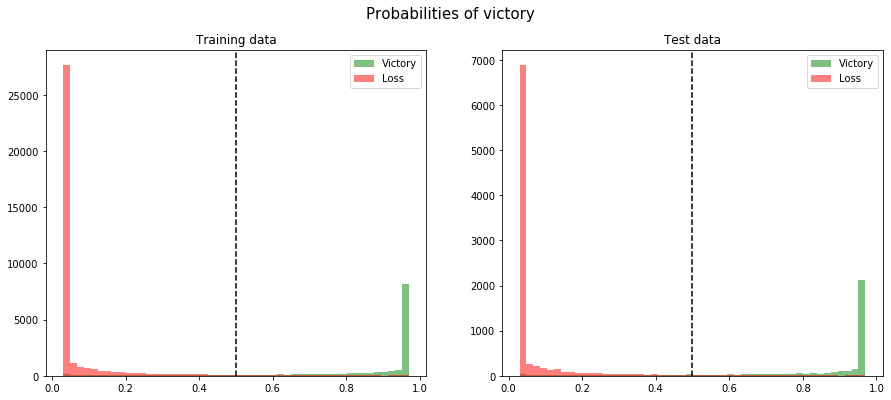

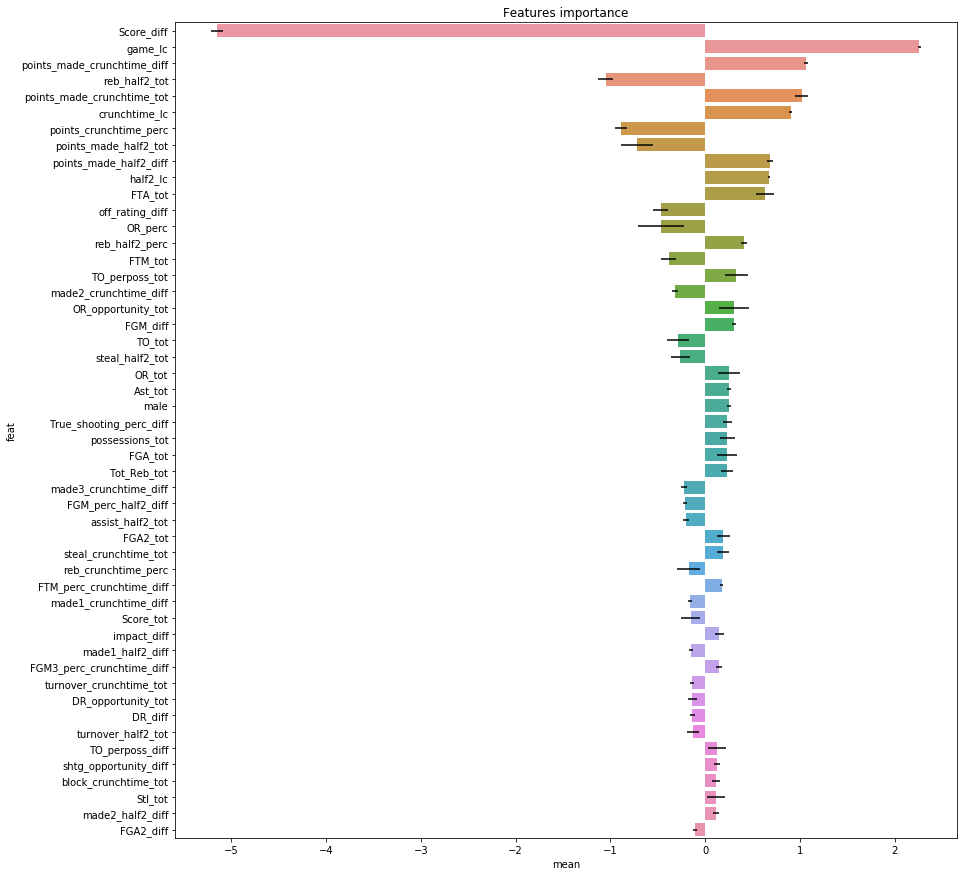

In [10]:
pipe = Pipeline([('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='clfs'))] + [('logit', LogisticRegression(solver='lbfgs', max_iter=5000))])

df_train = events_t[full_set]

grid = {'logit__C': np.arange(0.1, 3, 0.1), 
        'scl__method': ['standard', 'robust'], 
        #'feat_eng__lastyr': [True, False], 
        'feat_sel__k': [5, 10, 20, 50, 70, 100, 'all']}

fitted_log, oof_pred_log, test_pred_log, imp_coef_log, train_log, y_train_log, test_log, y_test_log = random_split(df_train, pipe, kfolds, 'competitive', predict_proba=True, tune=True, param_grid=grid)

rp.report_victory(y_train_log, y_test_log, oof_pred_log, test_pred_log, probs=True, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_log.head(50).reset_index(), 
            xerr=imp_coef_log.head(50)['std'])
plt.title(f'Features importance')
plt.show()

-0.17452311558991784
{'feat_sel__k': 'all', 'logit__C': 0.8, 'scl__method': 'robust'}
Accuracy train: 		 0.9262
Accuracy test: 			 0.924
AUC ROC train: 			 0.9124
AUC ROC test: 			 0.9096
Logloss train: 			 0.1881
Logloss test: 			 0.1896
Unsure train: 			 4.1545%
Unsure test: 			 4.4236%


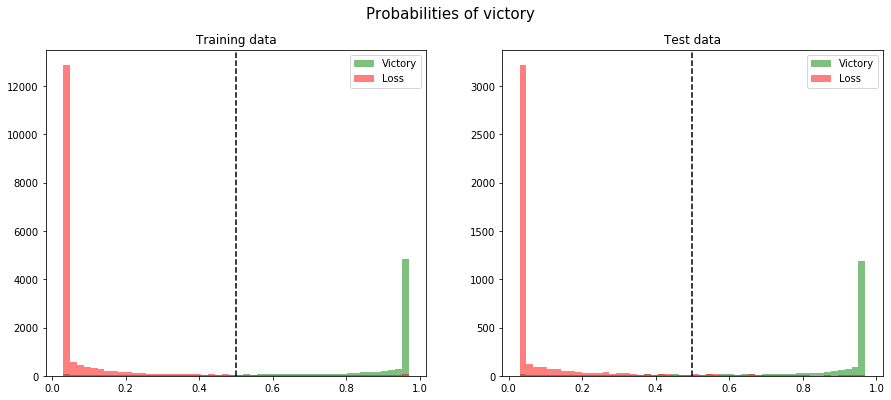

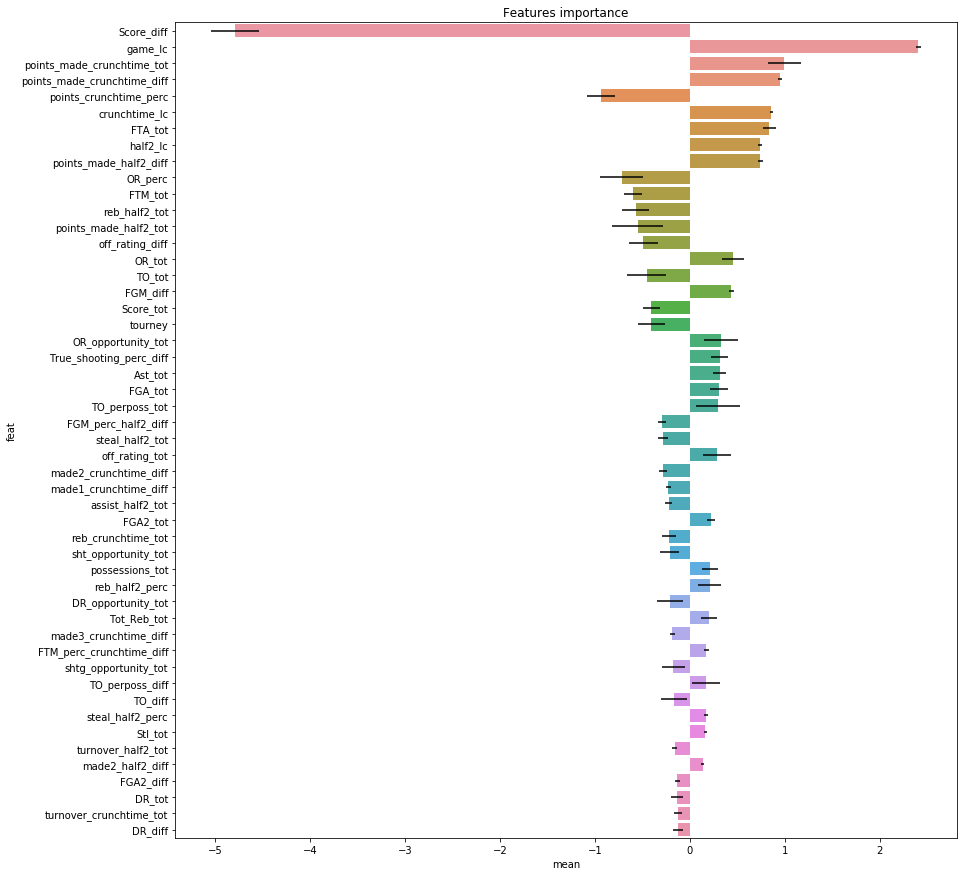

In [48]:
pipe = Pipeline([('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='clfs'))] + [('logit', LogisticRegression(solver='lbfgs', max_iter=5000))])

df_train = events_m[full_set].drop('male', axis=1)

grid = {'logit__C': np.arange(0.1, 3, 0.1), 
        'scl__method': ['standard', 'robust'], 
        #'feat_eng__lastyr': [True, False], 
        'feat_sel__k': [5, 10, 20, 50, 70, 100, 'all']}

fitted_log, oof_pred_log, test_pred_log, imp_coef_log, train_log, y_train_log, test_log, y_test_log = random_split(df_train, pipe, kfolds, 'competitive', predict_proba=True, tune=True, param_grid=grid)

rp.report_victory(y_train_log, y_test_log, oof_pred_log, test_pred_log, probs=True, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_log.head(50).reset_index(), 
            xerr=imp_coef_log.head(50)['std'])
plt.title(f'Features importance')
plt.show()

-0.15071582403166375
{'feat_sel__k': 'all', 'logit__C': 1.2000000000000002, 'scl__method': 'robust'}
Accuracy train: 		 0.9364
Accuracy test: 			 0.939
AUC ROC train: 			 0.9079
AUC ROC test: 			 0.9104
Logloss train: 			 0.1656
Logloss test: 			 0.1615
Unsure train: 			 3.4464%
Unsure test: 			 3.5657%


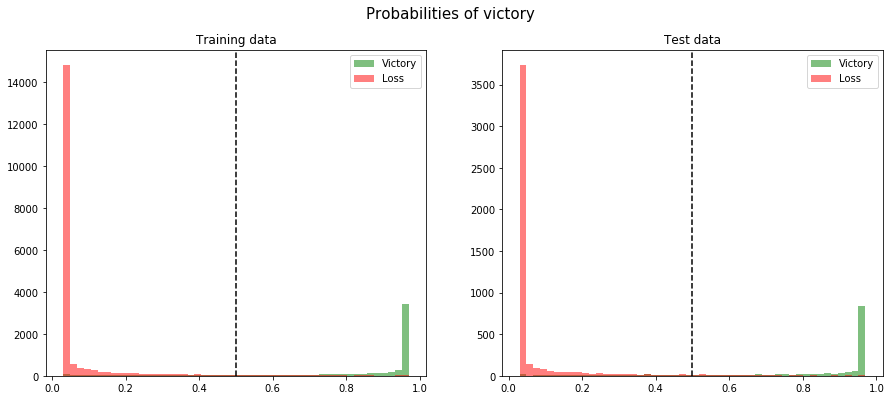

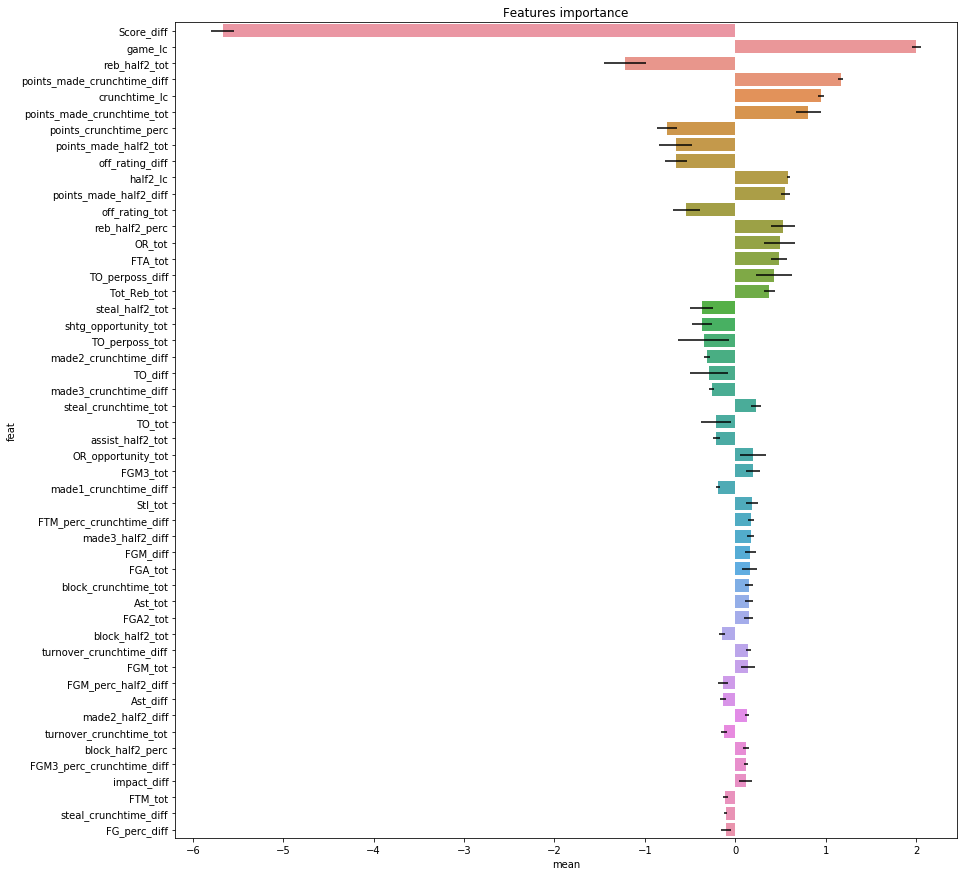

In [49]:
pipe = Pipeline([('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='clfs'))] + [('logit', LogisticRegression(solver='lbfgs', max_iter=5000))])

df_train = events_w[full_set].drop('male', axis=1)

grid = {'logit__C': np.arange(0.1, 3, 0.1), 
        'scl__method': ['standard', 'robust'], 
        #'feat_eng__lastyr': [True, False], 
        'feat_sel__k': [5, 10, 20, 50, 70, 100, 'all']}

fitted_log, oof_pred_log, test_pred_log, imp_coef_log, train_log, y_train_log, test_log, y_test_log = random_split(df_train, pipe, kfolds, 'competitive', predict_proba=True, tune=True, param_grid=grid)

rp.report_victory(y_train_log, y_test_log, oof_pred_log, test_pred_log, probs=True, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_log.head(50).reset_index(), 
            xerr=imp_coef_log.head(50)['std'])
plt.title(f'Features importance')
plt.show()

## Clean set

-0.3951181745693959
{'feat_sel__k': 'all', 'logit__C': 2.8000000000000003, 'scl__method': 'standard'}
Accuracy train: 		 0.8098
Accuracy test: 			 0.8061
AUC ROC train: 			 0.746
AUC ROC test: 			 0.742
Logloss train: 			 0.3979
Logloss test: 			 0.4026
Unsure train: 			 13.6894%
Unsure test: 			 13.3829%


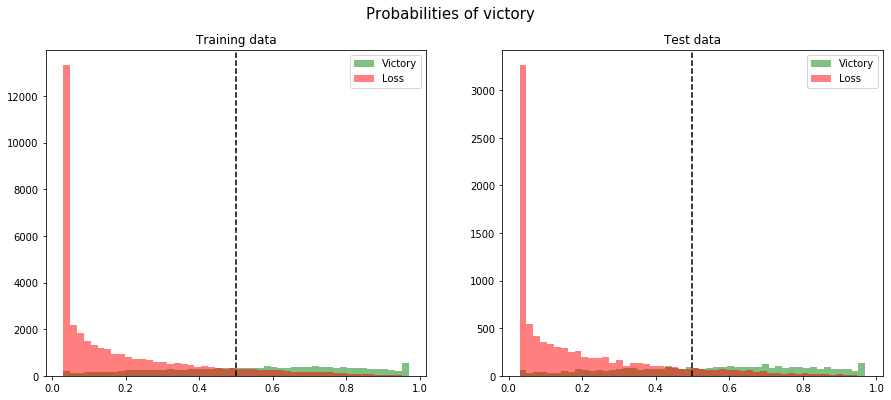

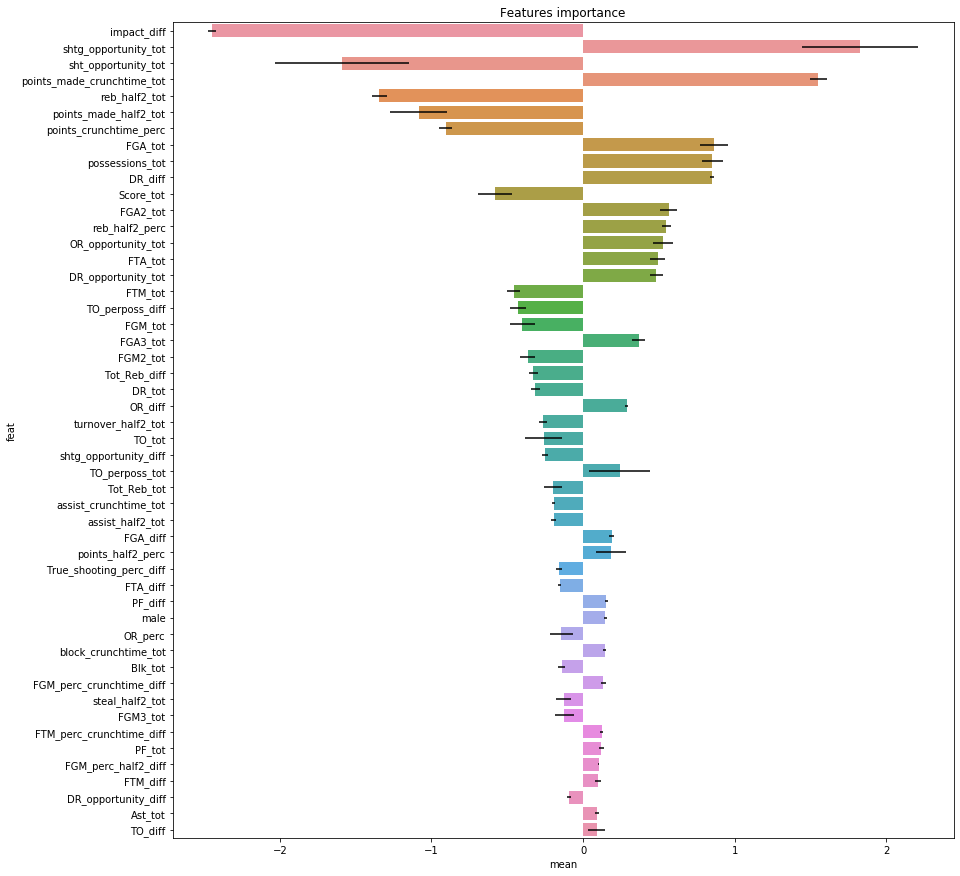

In [11]:
pipe = Pipeline([('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='clfs'))] + [('logit', LogisticRegression(solver='lbfgs', max_iter=5000))])

df_train = events_t[clean_set]

grid = {'logit__C': np.arange(0.1, 3, 0.1), 
        'scl__method': ['standard', 'robust'], 
        #'feat_eng__lastyr': [True, False], 
        'feat_sel__k': [5, 10, 20, 50, 70, 100, 'all']}

fitted_log, oof_pred_log, test_pred_log, imp_coef_log, train_log, y_train_log, test_log, y_test_log = random_split(df_train, pipe, kfolds, 'competitive', predict_proba=True, tune=True, param_grid=grid)

rp.report_victory(y_train_log, y_test_log, oof_pred_log, test_pred_log, probs=True, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_log.head(50).reset_index(), 
            xerr=imp_coef_log.head(50)['std'])
plt.title(f'Features importance')
plt.show()

-0.41029523887692354
{'feat_sel__k': 'all', 'logit__C': 1.1, 'scl__method': 'robust'}
Accuracy train: 		 0.8065
Accuracy test: 			 0.8146
AUC ROC train: 			 0.7666
AUC ROC test: 			 0.777
Logloss train: 			 0.4118
Logloss test: 			 0.407
Unsure train: 			 14.082%
Unsure test: 			 13.5327%


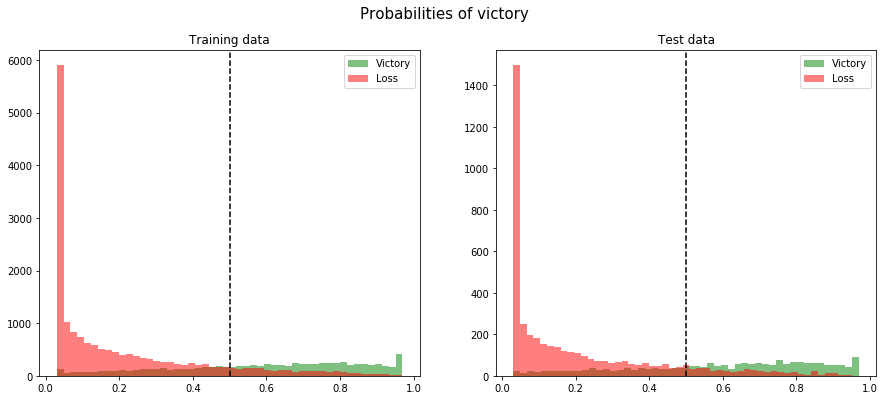

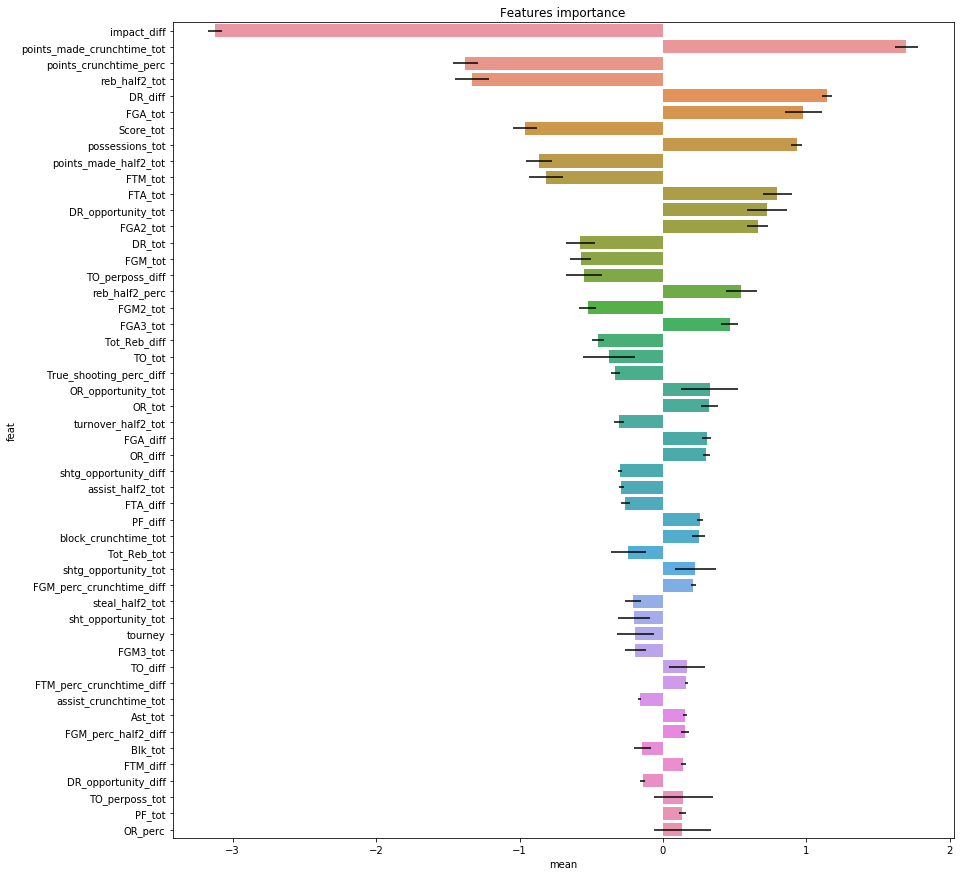

In [50]:
pipe = Pipeline([('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='clfs'))] + [('logit', LogisticRegression(solver='lbfgs', max_iter=5000))])

df_train = events_m[clean_set].drop('male', axis=1)

grid = {'logit__C': np.arange(0.1, 3, 0.1), 
        'scl__method': ['standard', 'robust'], 
        #'feat_eng__lastyr': [True, False], 
        'feat_sel__k': [5, 10, 20, 50, 70, 100, 'all']}

fitted_log, oof_pred_log, test_pred_log, imp_coef_log, train_log, y_train_log, test_log, y_test_log = random_split(df_train, pipe, kfolds, 'competitive', predict_proba=True, tune=True, param_grid=grid)

rp.report_victory(y_train_log, y_test_log, oof_pred_log, test_pred_log, probs=True, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_log.head(50).reset_index(), 
            xerr=imp_coef_log.head(50)['std'])
plt.title(f'Features importance')
plt.show()

-0.3779370412110386
{'feat_sel__k': 'all', 'logit__C': 2.7, 'scl__method': 'standard'}
Accuracy train: 		 0.8147
Accuracy test: 			 0.8112
AUC ROC train: 			 0.7182
AUC ROC test: 			 0.7062
Logloss train: 			 0.3824
Logloss test: 			 0.3856
Unsure train: 			 13.0611%
Unsure test: 			 12.496%


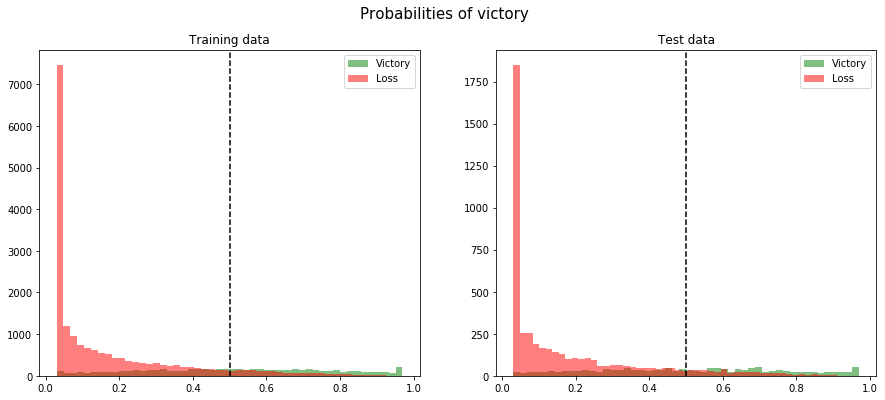

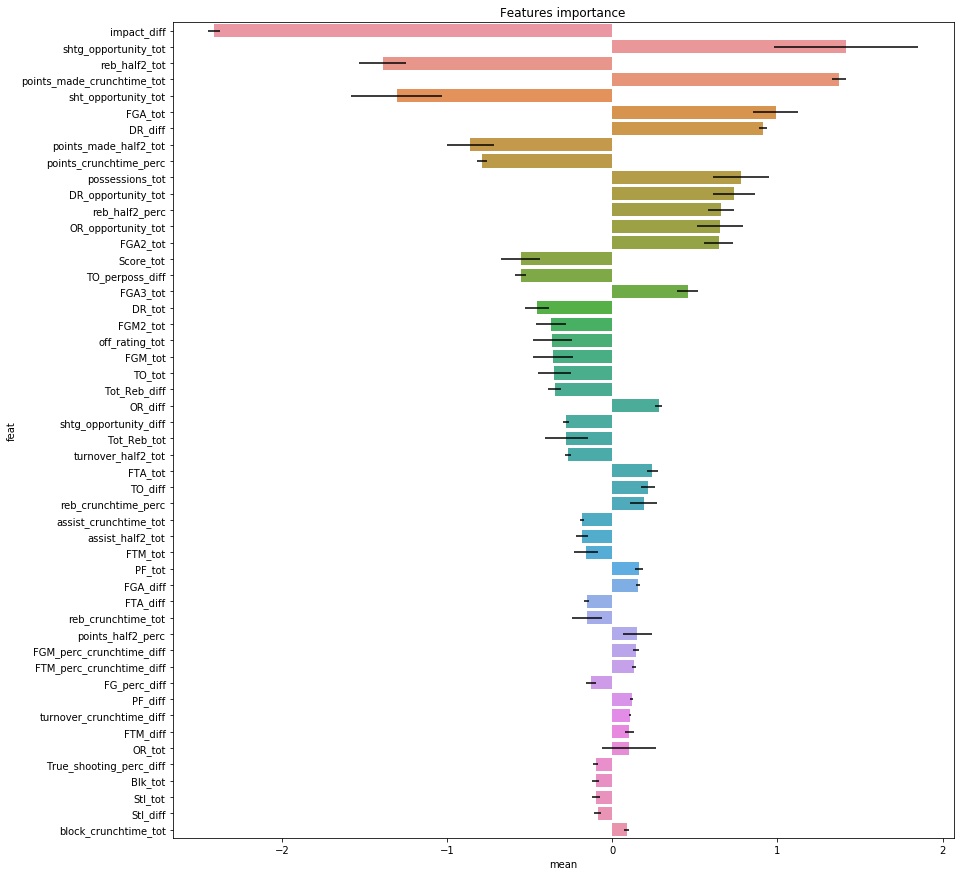

In [51]:
pipe = Pipeline([('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='clfs'))] + [('logit', LogisticRegression(solver='lbfgs', max_iter=5000))])

df_train = events_w[clean_set].drop('male', axis=1)

grid = {'logit__C': np.arange(0.1, 3, 0.1), 
        'scl__method': ['standard', 'robust'], 
        #'feat_eng__lastyr': [True, False], 
        'feat_sel__k': [5, 10, 20, 50, 70, 100, 'all']}

fitted_log, oof_pred_log, test_pred_log, imp_coef_log, train_log, y_train_log, test_log, y_test_log = random_split(df_train, pipe, kfolds, 'competitive', predict_proba=True, tune=True, param_grid=grid)

rp.report_victory(y_train_log, y_test_log, oof_pred_log, test_pred_log, probs=True, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_log.head(50).reset_index(), 
            xerr=imp_coef_log.head(50)['std'])
plt.title(f'Features importance')
plt.show()

# Xgboost

Accuracy train: 		 0.8729
Accuracy test: 			 0.8742
AUC ROC train: 			 0.8346
AUC ROC test: 			 0.8377
Logloss train: 			 0.2998
Logloss test: 			 0.2995
Unsure train: 			 7.0503%
Unsure test: 			 7.1731%


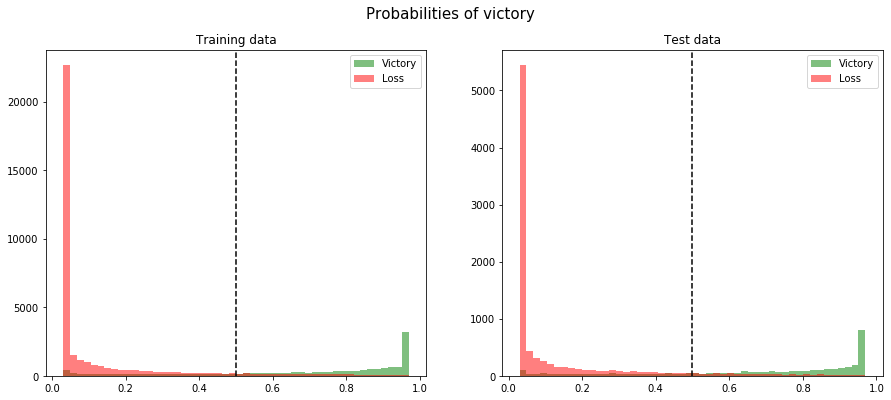

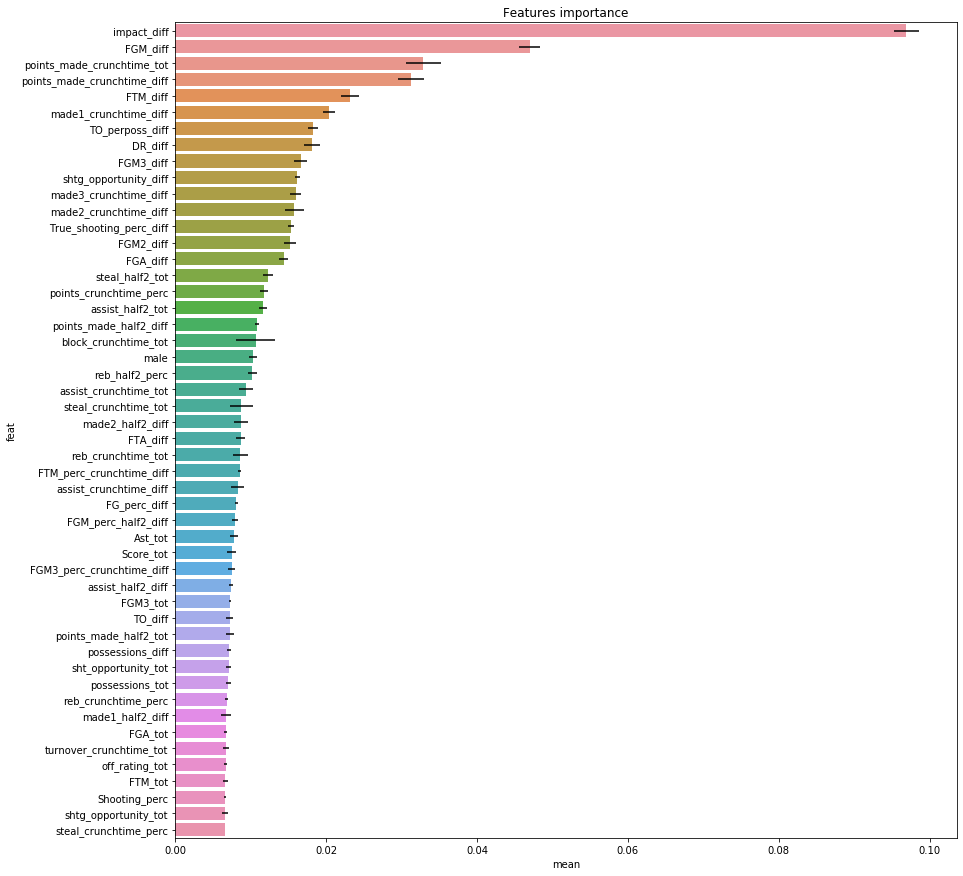

In [9]:
pipe = Pipeline([('scl', df_p.df_imputer())] + 
                [('xgb', XGBClassifier(objective='binary:logistic', 
                                       subsample=0.8,
                                       n_jobs=5, 
                                       max_depth=5, 
                                       learning_rate=0.1, 
                                       n_estimators=800))])

df_train = events_t[custom_set]

fitted_log, oof_pred_log, test_pred_log, imp_coef_log, train_log, y_train_log, test_log, y_test_log = random_split(df_train, pipe, kfolds, 'competitive', predict_proba=True)

rp.report_victory(y_train_log, y_test_log, oof_pred_log, test_pred_log, probs=True, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_log.head(50).reset_index(), 
            xerr=imp_coef_log.head(50)['std'])
plt.title(f'Features importance')
plt.show()

# Making the score

In [29]:
def get_pdp(clf, feature, data, fold):
    val, exes = partial_dependence(clf, features=feature, 
                                   X=data, grid_resolution=50)
    fold_tmp = pd.DataFrame({'x': exes[0], 'y': val[0]})
    fold_tmp['feat'] = feature
    fold_tmp['fold'] = fold + 1
    
    return fold_tmp


def xgb_train(train, target, kfolds):

    oof = np.zeros(len(train))
    pd.options.mode.chained_assignment = None 
    
    feat_df = pd.DataFrame()
    feat_pdp = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(kfolds.split(train.values, target.values)):
        print("fold n°{}".format(fold_ + 1))
        
        trn_data = train.iloc[trn_idx].copy()
        val_data = train.iloc[val_idx].copy()
        
        trn_target = target.iloc[trn_idx]
        val_target = target.iloc[val_idx]

        
        clf = XGBClassifier(objective='binary:logistic', 
                                       subsample=0.8,
                                       n_jobs=5, 
                                       max_depth=8, 
                                       learning_rate=0.05, 
                                       n_estimators=10000).fit(trn_data, 
                                                             trn_target,
                                                             eval_set=[(val_data, val_target)], 
                                                             eval_metric='logloss', 
                                                             early_stopping_rounds=100, 
                                                             verbose=500)
        
        oof[val_idx] = clf.predict_proba(val_data, ntree_limit=clf.best_iteration)[:,1]
        #'off_rating_diff', 
        for feat in ['impact_diff', 'FGM_diff', 'points_made_half2_diff', 'reb_crunchtime_tot', 
                     'points_made_crunchtime_tot', 'steal_half2_tot', 'points_half2_perc', 'Score_tot']:
            fold_tmp = get_pdp(clf, feat, trn_data, fold_)
            feat_pdp = pd.concat([feat_pdp, fold_tmp], axis=0)
        
        fold_df = pd.DataFrame()
        fold_df["feat"] = trn_data.columns
        fold_df["score"] = clf.feature_importances_     
        fold_df['fold'] = fold_ + 1
        feat_df = pd.concat([feat_df, fold_df], axis=0)
       

    feat_df = feat_df.groupby('feat')['score'].agg(['mean', 'std'])
    feat_df['abs_sco'] = (abs(feat_df['mean']))
    feat_df = feat_df.sort_values(by=['abs_sco'],ascending=False)
    del feat_df['abs_sco']

    print("CV score: {:<8.5f}".format(log_loss(y_true=target, y_pred=oof)))
    pd.options.mode.chained_assignment = 'warn'
    
    return oof, feat_df, feat_pdp

fold n°1
[0]	validation_0-logloss:0.66829
Will train until validation_0-logloss hasn't improved in 100 rounds.
[500]	validation_0-logloss:0.28544
Stopping. Best iteration:
[478]	validation_0-logloss:0.28496

fold n°2
[0]	validation_0-logloss:0.66812
Will train until validation_0-logloss hasn't improved in 100 rounds.
[500]	validation_0-logloss:0.28353
Stopping. Best iteration:
[456]	validation_0-logloss:0.28319

fold n°3
[0]	validation_0-logloss:0.66823
Will train until validation_0-logloss hasn't improved in 100 rounds.
[500]	validation_0-logloss:0.28791
Stopping. Best iteration:
[402]	validation_0-logloss:0.28732

fold n°4
[0]	validation_0-logloss:0.66862
Will train until validation_0-logloss hasn't improved in 100 rounds.
[500]	validation_0-logloss:0.28429
Stopping. Best iteration:
[524]	validation_0-logloss:0.28411

fold n°5
[0]	validation_0-logloss:0.66832
Will train until validation_0-logloss hasn't improved in 100 rounds.
[500]	validation_0-logloss:0.28399
Stopping. Best iterati

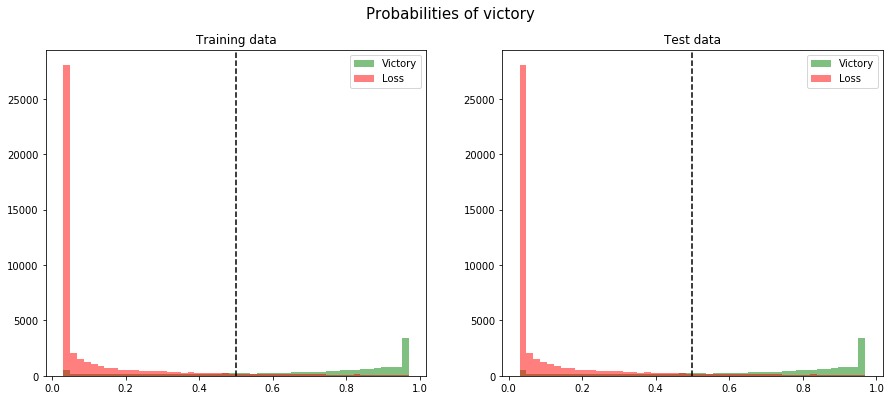

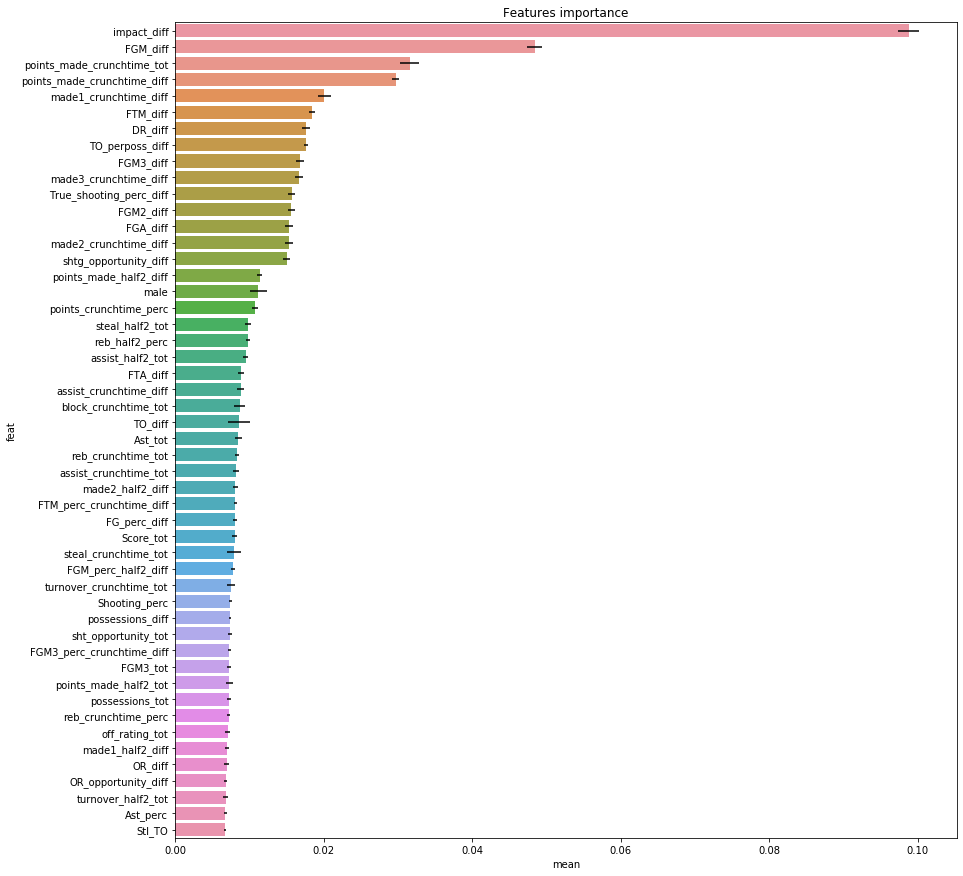

In [30]:
oof, feat_imp, pdps = xgb_train(events_t[custom_set].drop(['competitive'], axis=1), events_t.competitive, kfolds)

rp.report_victory(events_t.competitive, events_t.competitive, oof, oof, probs=True, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=feat_imp.head(50).reset_index(), 
            xerr=feat_imp.head(50)['std'])
plt.title(f'Features importance')
plt.show()

In [31]:
tmp = pdps.groupby(['feat', 'x']).y.agg(['mean', 'std']).reset_index()

In [32]:
def plot_pdp(data, feature):
    fig, ax = plt.subplots(1,1, figsize=(10, 6), facecolor='#f7f7f7')

    data[data.feat==feature].plot(ax=ax, x='x', y='mean')
    ax.fill_between(data[data.feat==feature].x, (data[data.feat==feature]['mean'] - data[data.feat==feature]['std']).astype(float),
                                (data[data.feat==feature]['mean'] + data[data.feat==feature]['std']).astype(float), alpha=0.1, color='r')
    ax.set_title(feature, fontsize=14)
    plt.show()

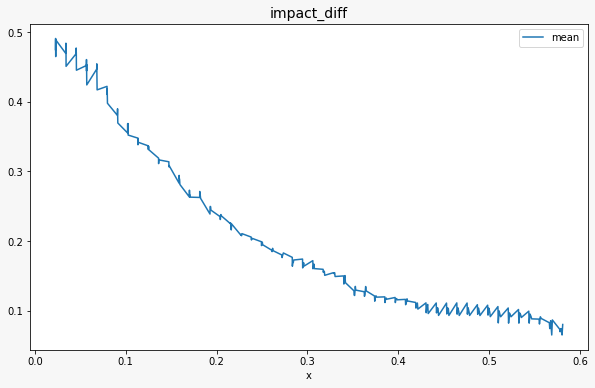

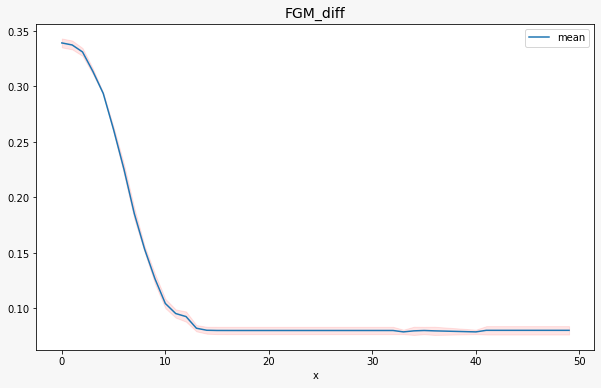

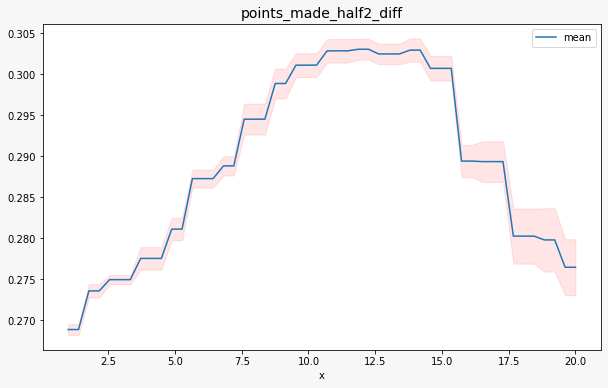

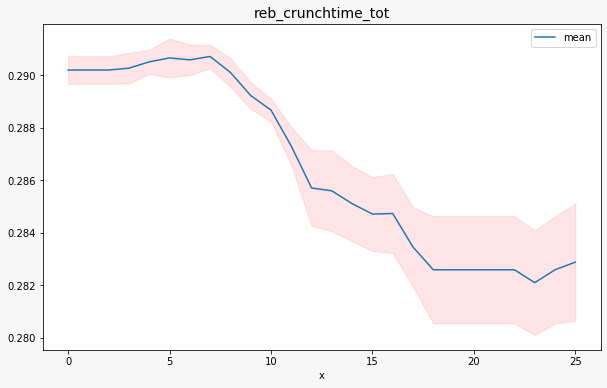

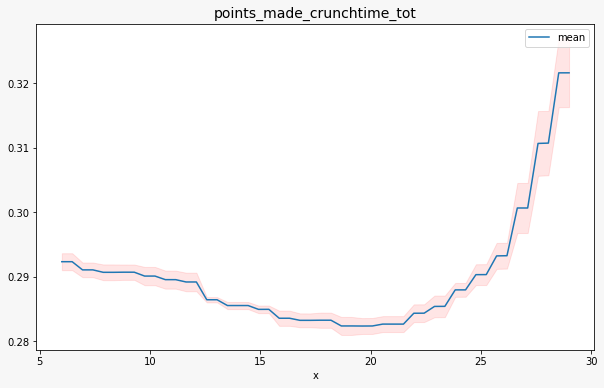

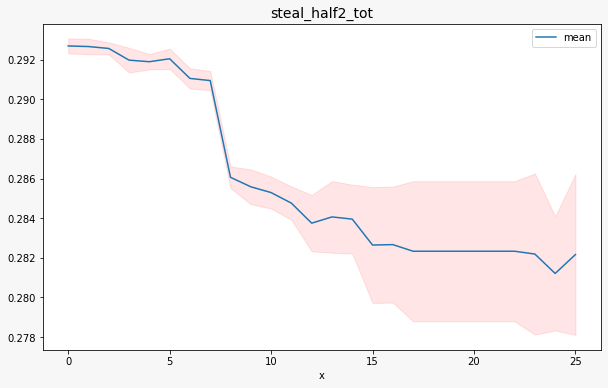

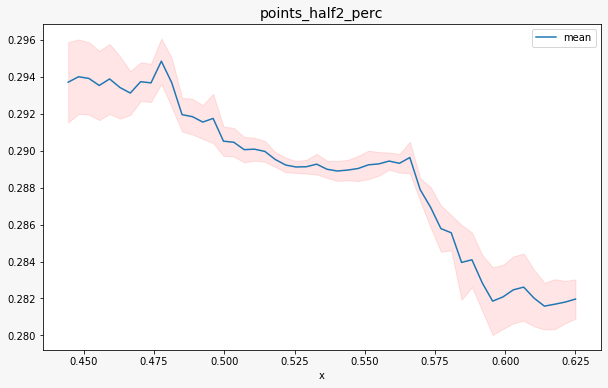

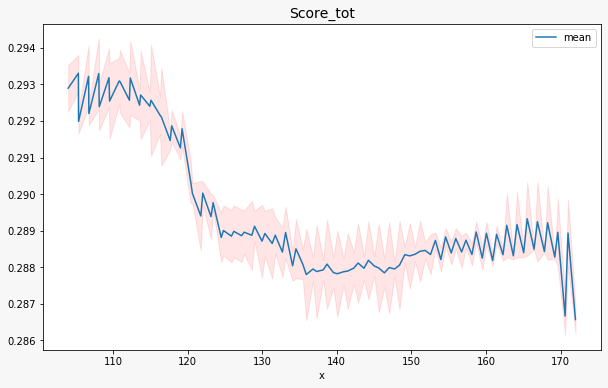

In [33]:
for col in ['impact_diff', 'FGM_diff', 'points_made_half2_diff', 'reb_crunchtime_tot', 
                     'points_made_crunchtime_tot', 'steal_half2_tot', 'points_half2_perc', 'Score_tot']:
    plot_pdp(tmp, col)

In [34]:
ids = events_t[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'tourney', 'male', 'game_lc', 'half2_lc', 'crunchtime_lc', 'competitive', 'Score_diff']].copy()

ids['competitive_score'] = oof

ids.head()

,Season,DayNum,WTeamID,LTeamID,tourney,male,game_lc,half2_lc,crunchtime_lc,competitive,Score_diff,competitive_score
0,2015,11,1103,1420,0,1,12.0,0.0,0.0,0,17,0.043550
1,2015,11,1104,1406,0,1,4.0,0.0,0.0,0,28,0.000647
2,2015,11,1112,1291,0,1,3.0,0.0,0.0,0,23,0.000878
3,2015,11,1113,1152,0,1,6.0,0.0,0.0,0,36,0.000424
4,2015,11,1119,1102,0,1,3.0,0.0,0.0,0,6,0.504394


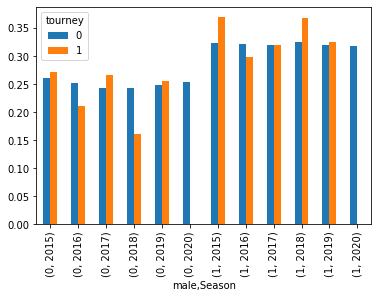

In [31]:
ids.groupby(['male', 'Season', 'tourney']).competitive_score.mean().unstack(2).plot(kind='bar')

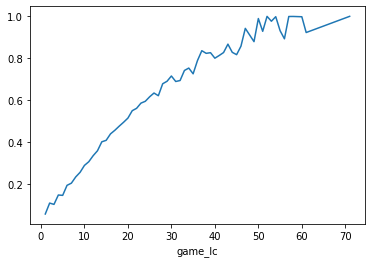

In [35]:
ids.groupby('game_lc').competitive_score.mean().plot()

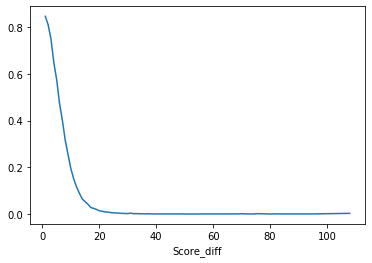

In [36]:
ids.groupby('Score_diff').competitive_score.mean().plot()

In [5]:
ids.to_csv('data/comp_score.csv', index=False)

NameError: name 'ids' is not defined

In [6]:
ids = pd.read_csv('data/comp_score.csv')

ids['residual'] = ids.competitive - ids.competitive_score

ids.head()

,Season,DayNum,WTeamID,LTeamID,tourney,male,game_lc,half2_lc,crunchtime_lc,competitive,Score_diff,competitive_score,residual
0,2015,11,1103,1420,0,1,12.0,0.0,0.0,0,17,0.043550,-0.043550
1,2015,11,1104,1406,0,1,4.0,0.0,0.0,0,28,0.000647,-0.000647
2,2015,11,1112,1291,0,1,3.0,0.0,0.0,0,23,0.000878,-0.000878
3,2015,11,1113,1152,0,1,6.0,0.0,0.0,0,36,0.000424,-0.000424
4,2015,11,1119,1102,0,1,3.0,0.0,0.0,0,6,0.504394,-0.504394


In [7]:
ids.sort_values('residual').tail(20)

,Season,DayNum,WTeamID,LTeamID,tourney,male,game_lc,half2_lc,crunchtime_lc,competitive,Score_diff,competitive_score,residual
27657,2020,20,1403,1254,0,1,29.0,2.0,0.0,1,30,0.002721,0.997279
46075,2017,89,3103,3185,0,0,21.0,6.0,0.0,1,18,0.002608,0.997392
17227,2018,36,1318,1137,0,1,23.0,0.0,0.0,1,18,0.002558,0.997442
27029,2020,6,1217,1263,0,1,23.0,9.0,0.0,1,21,0.002444,0.997556
26294,2019,119,1438,1393,0,1,27.0,7.0,0.0,1,26,0.002369,0.997631
58237,2019,126,3157,3117,0,0,26.0,3.0,0.0,1,14,0.002107,0.997893
49665,2018,50,3304,3194,0,0,19.0,11.0,0.0,1,17,0.002052,0.997948
45561,2017,76,3228,3304,0,0,23.0,11.0,0.0,1,20,0.001731,0.998269
48019,2018,11,3275,3178,0,0,22.0,0.0,0.0,1,27,0.001486,0.998514
42424,2016,122,3218,3364,0,0,21.0,5.0,0.0,1,14,0.001452,0.998548


In [53]:
ids.sort_values('competitive_score', ascending=False).head(10)

,Season,DayNum,WTeamID,LTeamID,tourney,male,game_lc,half2_lc,crunchtime_lc,competitive,Score_diff,competitive_score,residual
28714,2020,74,3425,3417,0,0,12.0,2.0,1.0,1,2,0.999972,0.000028
25593,2019,120,3269,3206,0,0,28.0,10.0,4.0,1,6,0.999965,0.000035
29325,2020,88,3113,3425,0,0,29.0,4.0,4.0,1,1,0.999964,0.000036
20540,2018,111,1284,1373,0,1,37.0,14.0,2.0,1,4,0.999964,0.000036
6306,2016,30,1214,1319,0,1,15.0,2.0,2.0,1,4,0.999959,0.000041
1514,2015,45,3332,3365,0,0,33.0,1.0,1.0,1,4,0.999950,0.000050
7523,2016,63,1264,1373,0,1,23.0,8.0,1.0,1,5,0.999948,0.000052
27622,2020,19,1129,1334,0,1,34.0,14.0,6.0,1,6,0.999948,0.000052
22899,2019,61,3213,3370,0,0,23.0,3.0,1.0,1,1,0.999948,0.000052
3401,2015,89,3418,3402,0,0,21.0,7.0,3.0,1,2,0.999947,0.000053


In [100]:
ids[ids.competitive==1].sort_values('competitive_score').head(10)

,Season,DayNum,WTeamID,LTeamID,tourney,male,game_lc,half2_lc,crunchtime_lc,competitive,Score_diff,competitive_score,residual
31094,2020,125,3332,3390,0,0,21.0,0.0,0.0,1,33,0.000231,0.999769
20964,2019,5,3250,3148,0,0,21.0,0.0,0.0,1,26,0.000453,0.999547
11954,2017,37,1233,1192,0,1,22.0,0.0,0.0,1,17,0.000543,0.999457
2061,2015,61,3268,3304,0,0,21.0,1.0,0.0,1,28,0.000552,0.999448
8387,2016,87,3181,3338,0,0,21.0,0.0,0.0,1,22,0.000567,0.999433
14258,2017,93,1368,1311,0,1,22.0,1.0,0.0,1,28,0.000818,0.999182
8160,2016,82,3137,3131,0,0,21.0,0.0,0.0,1,18,0.000854,0.999146
20569,2018,124,3370,3430,0,0,22.0,0.0,0.0,1,30,0.000976,0.999024
5907,2016,25,3374,3168,0,0,16.0,15.0,0.0,1,21,0.001150,0.998850
15782,2017,125,1222,1187,0,1,21.0,2.0,0.0,1,22,0.001181,0.998819


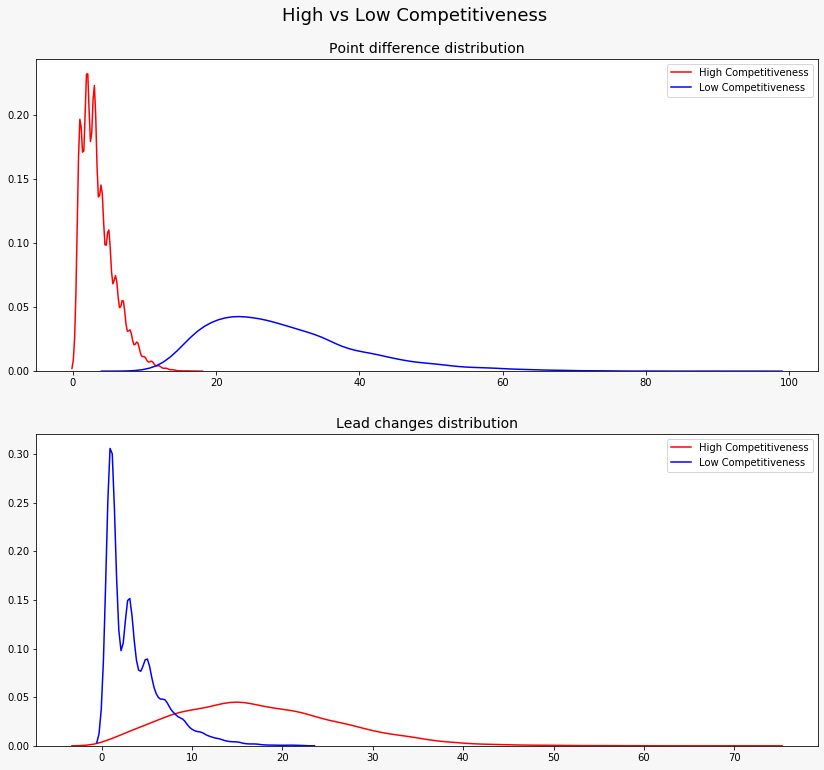

In [98]:
fig, ax = plt.subplots(2,1, figsize=(14, 12), facecolor='#f7f7f7')
fig.subplots_adjust(top=0.92)
fig.suptitle('High vs Low Competitiveness', fontsize=18)

high = ids.sort_values('competitive_score', ascending=False).head(10000)
low = ids.sort_values('competitive_score', ascending=False).tail(10000)

sns.kdeplot(high.Score_diff, ax=ax[0], label='High Competitiveness', color='r')
sns.kdeplot(low.Score_diff, ax=ax[0], label='Low Competitiveness', color='b')

sns.kdeplot(high.game_lc, ax=ax[1], label='High Competitiveness', color='r')
sns.kdeplot(low.game_lc, ax=ax[1], label='Low Competitiveness', color='b')

ax[0].set_title('Point difference distribution', fontsize=14)
ax[1].set_title('Lead changes distribution', fontsize=14)

plt.show()

# Pre game stats

In [38]:
men = pd.read_csv('data/processed_men/competitive.csv')
women = pd.read_csv('data/processed_women/competitive.csv')

men.head()

,Season,DayNum,WTeamID,LTeamID,tourney,Final_difference,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,competitive,Wgame_lc,Whalf2_lc,Wcrunchtime_lc,WScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,Wtop_team,Wupset,WOT_win,WAway,WFGM2,WFGA2,WTot_Reb,WFGM_no_ast,Wpossessions,Woff_rating,Wshtg_opportunity,WTO_perposs,Wdef_rating,Wopp_shtg_opportunity,Wopp_possessions,Wopp_score,Wopp_FTA,Wopp_FGA,Wimpact,WDR_opportunity,WOR_opportunity,Wpoints_made_half2,Wpoints_made_crunchtime,Wmade1_half2,Wmade2_half2,Wmade3_half2,Wreb_half2,Wturnover_half2,Wassist_half2,Wsteal_half2,Wblock_half2,Wmade1_crunchtime,Wmade2_crunchtime,Wmade3_crunchtime,Wreb_crunchtime,Wturnover_crunchtime,Wassist_crunchtime,Wsteal_crunchtime,Wblock_crunchtime,WScore_diff,WScore_advantage,WFGM_diff,WFGM_advantage,WFGA_diff,WFGA_advantage,WFGM3_diff,WFGM3_advantage,WFGA3_diff,WFGA3_advantage,WFTM_diff,WFTM_advantage,WFTA_diff,WFTA_advantage,WOR_diff,WOR_advantage,WDR_diff,WDR_advantage,WAst_diff,WAst_advantage,WTO_diff,WTO_advantage,WStl_diff,WStl_advantage,WBlk_diff,WBlk_advantage,WPF_diff,WPF_advantage,WFGM2_diff,WFGM2_advantage,WFGA2_diff,WFGA2_advantage,WTot_Reb_diff,WTot_Reb_advantage,WFGM_no_ast_diff,WFGM_no_ast_advantage,WDR_opportunity_diff,WDR_opportunity_advantage,WOR_opportunity_diff,WOR_opportunity_advantage,Wpossessions_diff,Wpossessions_advantage,Woff_rating_diff,Woff_rating_advantage,Wdef_rating_diff,Wdef_rating_advantage,Wshtg_opportunity_diff,Wshtg_opportunity_advantage,WTO_perposs_diff,WTO_perposs_advantage,Wimpact_diff,Wimpact_advantage,WTrue_shooting_perc_diff,WTrue_shooting_perc_advantage,WN_wins,WFGM_perc,WFGM2_perc,WFGM3_perc,WFT_perc,WFGM_no_ast_perc,WTrue_shooting_perc,WOpp_True_shooting_perc,Lgame_lc,Lhalf2_lc,Lcrunchtime_lc,LScore,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Ltop_team,Lupset,LOT_win,LAway,LFGM2,LFGA2,LTot_Reb,LFGM_no_ast,Lpossessions,Loff_rating,Lshtg_opportunity,LTO_perposs,Ldef_rating,Lopp_shtg_opportunity,Lopp_possessions,Lopp_score,Lopp_FTA,Lopp_FGA,Limpact,LDR_opportunity,LOR_opportunity,Lpoints_made_half2,Lpoints_made_crunchtime,Lmade1_half2,Lmade2_half2,Lmade3_half2,Lreb_half2,Lturnover_half2,Lassist_half2,Lsteal_half2,Lblock_half2,Lmade1_crunchtime,Lmade2_crunchtime,Lmade3_crunchtime,Lreb_crunchtime,Lturnover_crunchtime,Lassist_crunchtime,Lsteal_crunchtime,Lblock_crunchtime,LScore_diff,LScore_advantage,LFGM_diff,LFGM_advantage,LFGA_diff,LFGA_advantage,LFGM3_diff,LFGM3_advantage,LFGA3_diff,LFGA3_advantage,LFTM_diff,LFTM_advantage,LFTA_diff,LFTA_advantage,LOR_diff,LOR_advantage,LDR_diff,LDR_advantage,LAst_diff,LAst_advantage,LTO_diff,LTO_advantage,LStl_diff,LStl_advantage,LBlk_diff,LBlk_advantage,LPF_diff,LPF_advantage,LFGM2_diff,LFGM2_advantage,LFGA2_diff,LFGA2_advantage,LTot_Reb_diff,LTot_Reb_advantage,LFGM_no_ast_diff,LFGM_no_ast_advantage,LDR_opportunity_diff,LDR_opportunity_advantage,LOR_opportunity_diff,LOR_opportunity_advantage,Lpossessions_diff,Lpossessions_advantage,Loff_rating_diff,Loff_rating_advantage,Ldef_rating_diff,Ldef_rating_advantage,Lshtg_opportunity_diff,Lshtg_opportunity_advantage,LTO_perposs_diff,LTO_perposs_advantage,Limpact_diff,Limpact_advantage,LTrue_shooting_perc_diff,LTrue_shooting_perc_advantage,LN_wins,LFGM_perc,LFGM2_perc,LFGM3_perc,LFT_perc,LFGM_no_ast_perc,LTrue_shooting_perc,LOpp_True_shooting_perc
0,2015,12,1119,1440,0,6,-1.0,-1.0,22,10,3.0,1,3.0,0.0,0.0,84.0,30.0,61.0,13.0,25.0,11.0,17.0,17.0,20.0,18.0,15.0,6.0,4.0,21.0,0.0,0.0,0.0,0.0,17.0,36.0,37.0,12.0,67.075,125.232948,1.029817,0.223630,108.145581,0.958406,72.125,78.0,15.0,62.0,0.533113,0.645161,0.548387,38.0,7.0,7.0,7.0,5.0,21.0,10.0,7.0,4.0,2.0,5.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,6.0,1.0,-1.0,0.0,-1.0,0.0,7.0,1.0,6.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,4.0,1.0,-3.0,0.0,-2.0,0.0,-2.0,0.0,0.0,0.0,-8.0,0.0,-7.0,0.0,5.0,1.0,-5.0,0.0,0.096774,1.0,0.064516,1.0,-5.050,0.0,17.087368,1.0,-17.087368,0.0,0.071412,1.0,-0.025936,0.0,0.066225,1.0,0.043839,1.0,1.0,0.491803,0.472222,0.5

In [39]:
def proc_comp(data):
    df = data.copy()
    to_use = []

    for col in [col for col in men if 'W' in col and 'diff' not in col and 'TeamID' not in col and 'top_team' not in col and 'upset' not in col]:
        name = col.replace('W', '')
        df[name+'_30'] = abs(df['W'+name] - df['L'+name])
        to_use.append(name+'_30')
        
    return df, to_use

In [40]:
proc_men, using = proc_comp(men)
proc_women, using = proc_comp(women)

proc_men['men'] = 1
proc_women['men'] = 0

proc_all = pd.concat([proc_men, proc_women])

proc_all.head()

,Season,DayNum,WTeamID,LTeamID,tourney,Final_difference,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,competitive,Wgame_lc,Whalf2_lc,Wcrunchtime_lc,WScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,Wtop_team,Wupset,WOT_win,WAway,WFGM2,WFGA2,WTot_Reb,WFGM_no_ast,Wpossessions,Woff_rating,Wshtg_opportunity,WTO_perposs,Wdef_rating,Wopp_shtg_opportunity,Wopp_possessions,Wopp_score,Wopp_FTA,Wopp_FGA,Wimpact,WDR_opportunity,WOR_opportunity,Wpoints_made_half2,Wpoints_made_crunchtime,Wmade1_half2,Wmade2_half2,Wmade3_half2,Wreb_half2,Wturnover_half2,Wassist_half2,Wsteal_half2,Wblock_half2,Wmade1_crunchtime,Wmade2_crunchtime,Wmade3_crunchtime,Wreb_crunchtime,Wturnover_crunchtime,Wassist_crunchtime,Wsteal_crunchtime,Wblock_crunchtime,WScore_diff,WScore_advantage,WFGM_diff,WFGM_advantage,WFGA_diff,WFGA_advantage,WFGM3_diff,WFGM3_advantage,WFGA3_diff,WFGA3_advantage,WFTM_diff,WFTM_advantage,WFTA_diff,WFTA_advantage,WOR_diff,WOR_advantage,WDR_diff,WDR_advantage,WAst_diff,WAst_advantage,WTO_diff,WTO_advantage,WStl_diff,WStl_advantage,WBlk_diff,WBlk_advantage,WPF_diff,WPF_advantage,WFGM2_diff,WFGM2_advantage,WFGA2_diff,WFGA2_advantage,WTot_Reb_diff,WTot_Reb_advantage,WFGM_no_ast_diff,WFGM_no_ast_advantage,WDR_opportunity_diff,WDR_opportunity_advantage,WOR_opportunity_diff,WOR_opportunity_advantage,Wpossessions_diff,Wpossessions_advantage,Woff_rating_diff,Woff_rating_advantage,Wdef_rating_diff,Wdef_rating_advantage,Wshtg_opportunity_diff,Wshtg_opportunity_advantage,WTO_perposs_diff,WTO_perposs_advantage,Wimpact_diff,Wimpact_advantage,WTrue_shooting_perc_diff,WTrue_shooting_perc_advantage,WN_wins,WFGM_perc,WFGM2_perc,WFGM3_perc,WFT_perc,WFGM_no_ast_perc,WTrue_shooting_perc,WOpp_True_shooting_perc,Lgame_lc,Lhalf2_lc,Lcrunchtime_lc,LScore,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Ltop_team,Lupset,LOT_win,...,LFGM_diff,LFGM_advantage,LFGA_diff,LFGA_advantage,LFGM3_diff,LFGM3_advantage,LFGA3_diff,LFGA3_advantage,LFTM_diff,LFTM_advantage,LFTA_diff,LFTA_advantage,LOR_diff,LOR_advantage,LDR_diff,LDR_advantage,LAst_diff,LAst_advantage,LTO_diff,LTO_advantage,LStl_diff,LStl_advantage,LBlk_diff,LBlk_advantage,LPF_diff,LPF_advantage,LFGM2_diff,LFGM2_advantage,LFGA2_diff,LFGA2_advantage,LTot_Reb_diff,LTot_Reb_advantage,LFGM_no_ast_diff,LFGM_no_ast_advantage,LDR_opportunity_diff,LDR_opportunity_advantage,LOR_opportunity_diff,LOR_opportunity_advantage,Lpossessions_diff,Lpossessions_advantage,Loff_rating_diff,Loff_rating_advantage,Ldef_rating_diff,Ldef_rating_advantage,Lshtg_opportunity_diff,Lshtg_opportunity_advantage,LTO_perposs_diff,LTO_perposs_advantage,Limpact_diff,Limpact_advantage,LTrue_shooting_perc_diff,LTrue_shooting_perc_advantage,LN_wins,LFGM_perc,LFGM2_perc,LFGM3_perc,LFT_perc,LFGM_no_ast_perc,LTrue_shooting_perc,LOpp_True_shooting_perc,game_lc_30,half2_lc_30,crunchtime_lc_30,Score_30,FGM_30,FGA_30,FGM3_30,FGA3_30,FTM_30,FTA_30,OR_30,DR_30,Ast_30,TO_30,Stl_30,Blk_30,PF_30,OT_win_30,Away_30,FGM2_30,FGA2_30,Tot_Reb_30,FGM_no_ast_30,possessions_30,off_rating_30,shtg_opportunity_30,TO_perposs_30,def_rating_30,opp_shtg_opportunity_30,opp_possessions_30,opp_score_30,opp_FTA_30,opp_FGA_30,impact_30,DR_opportunity_30,OR_opportunity_30,points_made_half2_30,points_made_crunchtime_30,made1_half2_30,made2_half2_30,made3_half2_30,reb_half2_30,turnover_half2_30,assist_half2_30,steal_half2_30,block_half2_30,made1_crunchtime_30,made2_crunchtime_30,made3_crunchtime_30,reb_crunchtime_30,turnover_crunchtime_30,assist_crunchtime_30,steal_crunchtime_30,block_crunchtime_30,Score_advantage_30,FGM_advantage_30,FGA_advantage_30,FGM3_advantage_30,FGA3_advantage_30,FTM_advantage_30,FTA_advantage_30,OR_advantage_30,DR_advantage_30,Ast_advantage_30,TO_advantage_30,Stl_advantage_30,Blk_advantage_30,PF_advantage_30,FGM2_advantage_30,FGA2_advantage_30,Tot_Reb_advantage_30,FGM_no_ast_advantage_30,DR_opportunity_advantage_30,OR_opportunity_advantage_30,possessions_advantage_30,off_rating_advantage_30,def_rating_advantag

In [41]:
tot_train = pd.merge(proc_all, ids[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'competitive_score']], on=['Season', 'DayNum', 'WTeamID', 'LTeamID'])

tot_train.head()

,Season,DayNum,WTeamID,LTeamID,tourney,Final_difference,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,competitive,Wgame_lc,Whalf2_lc,Wcrunchtime_lc,WScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,Wtop_team,Wupset,WOT_win,WAway,WFGM2,WFGA2,WTot_Reb,WFGM_no_ast,Wpossessions,Woff_rating,Wshtg_opportunity,WTO_perposs,Wdef_rating,Wopp_shtg_opportunity,Wopp_possessions,Wopp_score,Wopp_FTA,Wopp_FGA,Wimpact,WDR_opportunity,WOR_opportunity,Wpoints_made_half2,Wpoints_made_crunchtime,Wmade1_half2,Wmade2_half2,Wmade3_half2,Wreb_half2,Wturnover_half2,Wassist_half2,Wsteal_half2,Wblock_half2,Wmade1_crunchtime,Wmade2_crunchtime,Wmade3_crunchtime,Wreb_crunchtime,Wturnover_crunchtime,Wassist_crunchtime,Wsteal_crunchtime,Wblock_crunchtime,WScore_diff,WScore_advantage,WFGM_diff,WFGM_advantage,WFGA_diff,WFGA_advantage,WFGM3_diff,WFGM3_advantage,WFGA3_diff,WFGA3_advantage,WFTM_diff,WFTM_advantage,WFTA_diff,WFTA_advantage,WOR_diff,WOR_advantage,WDR_diff,WDR_advantage,WAst_diff,WAst_advantage,WTO_diff,WTO_advantage,WStl_diff,WStl_advantage,WBlk_diff,WBlk_advantage,WPF_diff,WPF_advantage,WFGM2_diff,WFGM2_advantage,WFGA2_diff,WFGA2_advantage,WTot_Reb_diff,WTot_Reb_advantage,WFGM_no_ast_diff,WFGM_no_ast_advantage,WDR_opportunity_diff,WDR_opportunity_advantage,WOR_opportunity_diff,WOR_opportunity_advantage,Wpossessions_diff,Wpossessions_advantage,Woff_rating_diff,Woff_rating_advantage,Wdef_rating_diff,Wdef_rating_advantage,Wshtg_opportunity_diff,Wshtg_opportunity_advantage,WTO_perposs_diff,WTO_perposs_advantage,Wimpact_diff,Wimpact_advantage,WTrue_shooting_perc_diff,WTrue_shooting_perc_advantage,WN_wins,WFGM_perc,WFGM2_perc,WFGM3_perc,WFT_perc,WFGM_no_ast_perc,WTrue_shooting_perc,WOpp_True_shooting_perc,Lgame_lc,Lhalf2_lc,Lcrunchtime_lc,LScore,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Ltop_team,Lupset,LOT_win,...,LFGM_advantage,LFGA_diff,LFGA_advantage,LFGM3_diff,LFGM3_advantage,LFGA3_diff,LFGA3_advantage,LFTM_diff,LFTM_advantage,LFTA_diff,LFTA_advantage,LOR_diff,LOR_advantage,LDR_diff,LDR_advantage,LAst_diff,LAst_advantage,LTO_diff,LTO_advantage,LStl_diff,LStl_advantage,LBlk_diff,LBlk_advantage,LPF_diff,LPF_advantage,LFGM2_diff,LFGM2_advantage,LFGA2_diff,LFGA2_advantage,LTot_Reb_diff,LTot_Reb_advantage,LFGM_no_ast_diff,LFGM_no_ast_advantage,LDR_opportunity_diff,LDR_opportunity_advantage,LOR_opportunity_diff,LOR_opportunity_advantage,Lpossessions_diff,Lpossessions_advantage,Loff_rating_diff,Loff_rating_advantage,Ldef_rating_diff,Ldef_rating_advantage,Lshtg_opportunity_diff,Lshtg_opportunity_advantage,LTO_perposs_diff,LTO_perposs_advantage,Limpact_diff,Limpact_advantage,LTrue_shooting_perc_diff,LTrue_shooting_perc_advantage,LN_wins,LFGM_perc,LFGM2_perc,LFGM3_perc,LFT_perc,LFGM_no_ast_perc,LTrue_shooting_perc,LOpp_True_shooting_perc,game_lc_30,half2_lc_30,crunchtime_lc_30,Score_30,FGM_30,FGA_30,FGM3_30,FGA3_30,FTM_30,FTA_30,OR_30,DR_30,Ast_30,TO_30,Stl_30,Blk_30,PF_30,OT_win_30,Away_30,FGM2_30,FGA2_30,Tot_Reb_30,FGM_no_ast_30,possessions_30,off_rating_30,shtg_opportunity_30,TO_perposs_30,def_rating_30,opp_shtg_opportunity_30,opp_possessions_30,opp_score_30,opp_FTA_30,opp_FGA_30,impact_30,DR_opportunity_30,OR_opportunity_30,points_made_half2_30,points_made_crunchtime_30,made1_half2_30,made2_half2_30,made3_half2_30,reb_half2_30,turnover_half2_30,assist_half2_30,steal_half2_30,block_half2_30,made1_crunchtime_30,made2_crunchtime_30,made3_crunchtime_30,reb_crunchtime_30,turnover_crunchtime_30,assist_crunchtime_30,steal_crunchtime_30,block_crunchtime_30,Score_advantage_30,FGM_advantage_30,FGA_advantage_30,FGM3_advantage_30,FGA3_advantage_30,FTM_advantage_30,FTA_advantage_30,OR_advantage_30,DR_advantage_30,Ast_advantage_30,TO_advantage_30,Stl_advantage_30,Blk_advantage_30,PF_advantage_30,FGM2_advantage_30,FGA2_advantage_30,Tot_Reb_advantage_30,FGM_no_ast_advantage_30,DR_opportunity_advantage_30,OR_opportunity_advantage_30,possessions_advantage_30,off_rating_advantage_30,def_rating_advantage_30,shtg_

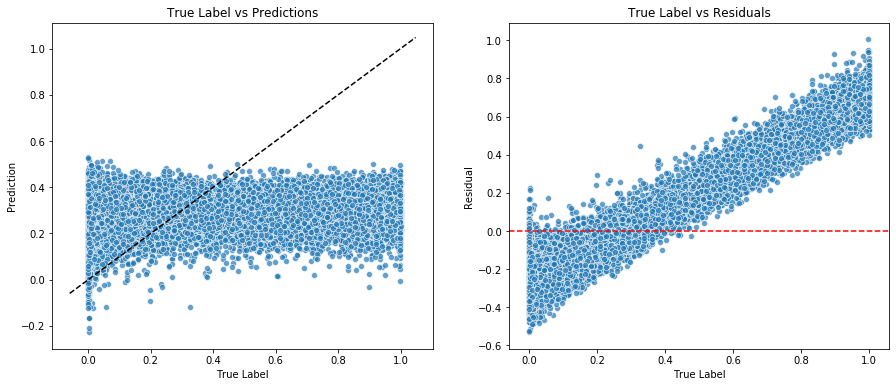

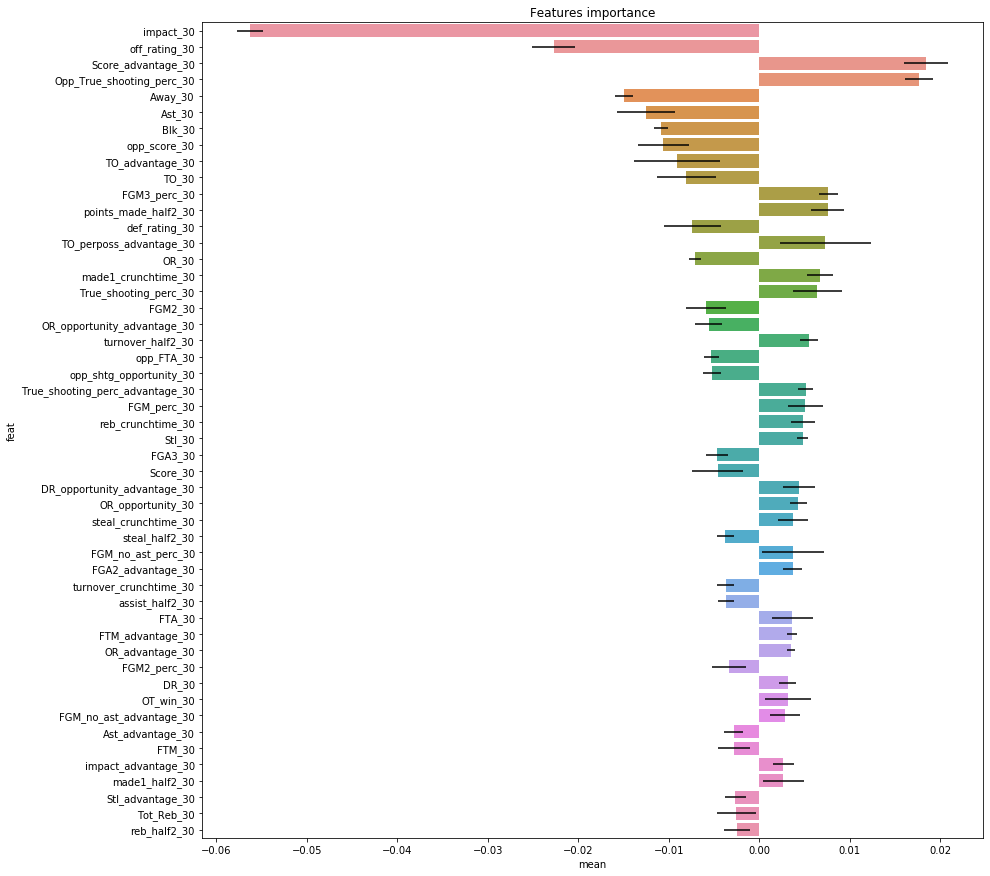

In [49]:
pipe = Pipeline([('scl', df_p.df_scaler())] + 
                [('ridge', Lasso(alpha=0.00001))])

df_train = tot_train[using + ['competitive_score']]

fitted_log, oof_pred_log, test_pred_log, imp_coef_log, train_log, y_train_log, test_log, y_test_log = random_split(df_train, pipe, kfolds, 'competitive_score')

rp.plot_predictions(train_log, y_train_log, oof_pred_log, feature=None, hue=None, legend=False, savename=None)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_log.head(50).reset_index(), 
            xerr=imp_coef_log.head(50)['std'])
plt.title(f'Features importance')
plt.show()

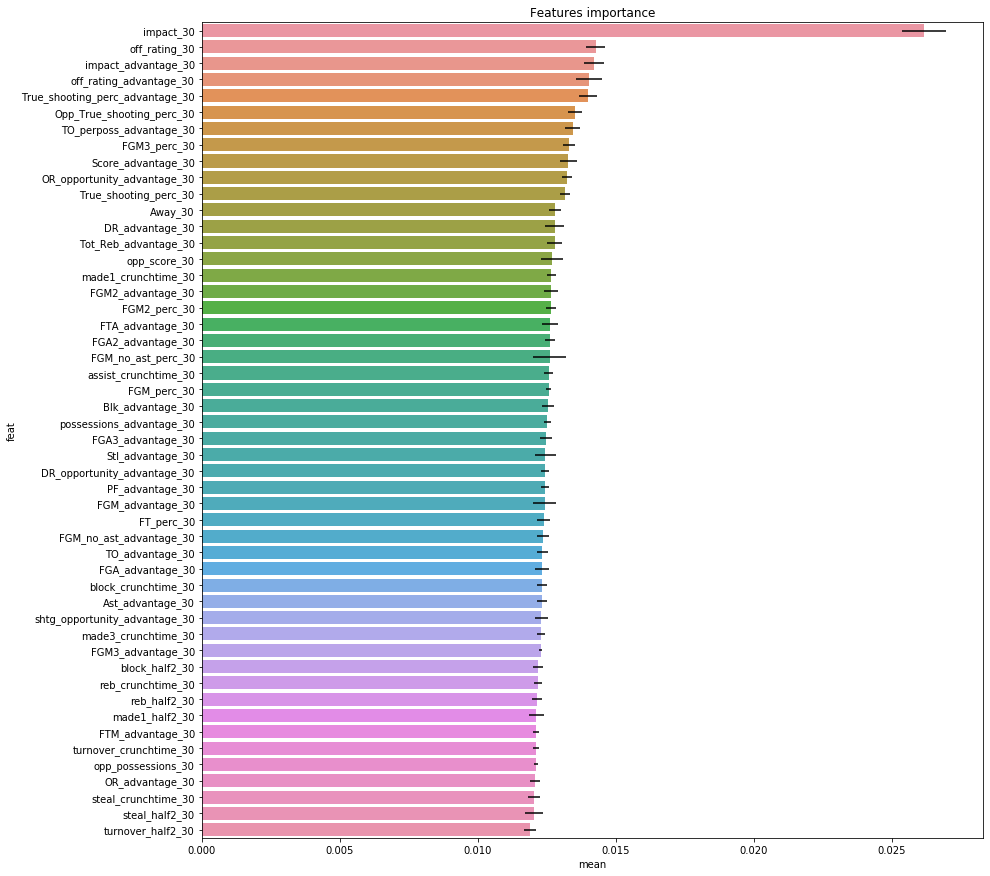

In [32]:
pipe = Pipeline([('scl', df_p.df_imputer())] + 
                [('xgb', XGBRegressor(objective='reg:squarederror', 
                                       subsample=0.8,
                                       n_jobs=5, 
                                       max_depth=12, 
                                       learning_rate=0.01, 
                                       n_estimators=500))])

df_train = tot_train[using + ['competitive_score']]

fitted_log, oof_pred_log, test_pred_log, imp_coef_log, train_log, y_train_log, test_log, y_test_log = random_split(df_train, pipe, kfolds, 'competitive_score')

#rp.report_points(train_log, test_log, y_train_log, y_test_log, oof_pred_log, test_pred_log, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_log.head(50).reset_index(), 
            xerr=imp_coef_log.head(50)['std'])
plt.title(f'Features importance')
plt.show()

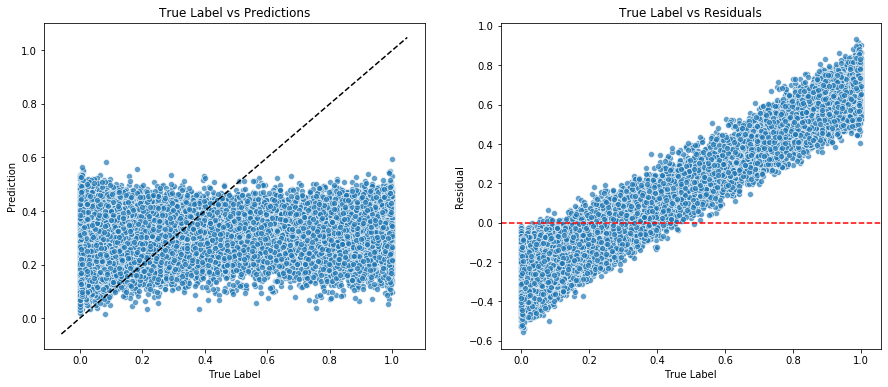

In [33]:
rp.plot_predictions(train_log, y_train_log, oof_pred_log, feature=None, hue=None, legend=False, savename=None)

In [21]:
len(oof)

63846

In [43]:
to_use = [col for col in proc_all if 'difference' not in col and 'lc' not in col and 'TeamID' not in col and 'top_team' not in col and 'upset' not in col]
proc_all[to_use].head()

,Season,DayNum,tourney,competitive,WScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,WOT_win,WAway,WFGM2,WFGA2,WTot_Reb,WFGM_no_ast,Wpossessions,Woff_rating,Wshtg_opportunity,WTO_perposs,Wdef_rating,Wopp_shtg_opportunity,Wopp_possessions,Wopp_score,Wopp_FTA,Wopp_FGA,Wimpact,WDR_opportunity,WOR_opportunity,Wpoints_made_half2,Wpoints_made_crunchtime,Wmade1_half2,Wmade2_half2,Wmade3_half2,Wreb_half2,Wturnover_half2,Wassist_half2,Wsteal_half2,Wblock_half2,Wmade1_crunchtime,Wmade2_crunchtime,Wmade3_crunchtime,Wreb_crunchtime,Wturnover_crunchtime,Wassist_crunchtime,Wsteal_crunchtime,Wblock_crunchtime,WScore_diff,WScore_advantage,WFGM_diff,WFGM_advantage,WFGA_diff,WFGA_advantage,WFGM3_diff,WFGM3_advantage,WFGA3_diff,WFGA3_advantage,WFTM_diff,WFTM_advantage,WFTA_diff,WFTA_advantage,WOR_diff,WOR_advantage,WDR_diff,WDR_advantage,WAst_diff,WAst_advantage,WTO_diff,WTO_advantage,WStl_diff,WStl_advantage,WBlk_diff,WBlk_advantage,WPF_diff,WPF_advantage,WFGM2_diff,WFGM2_advantage,WFGA2_diff,WFGA2_advantage,WTot_Reb_diff,WTot_Reb_advantage,WFGM_no_ast_diff,WFGM_no_ast_advantage,WDR_opportunity_diff,WDR_opportunity_advantage,WOR_opportunity_diff,WOR_opportunity_advantage,Wpossessions_diff,Wpossessions_advantage,Woff_rating_diff,Woff_rating_advantage,Wdef_rating_diff,Wdef_rating_advantage,Wshtg_opportunity_diff,Wshtg_opportunity_advantage,WTO_perposs_diff,WTO_perposs_advantage,Wimpact_diff,Wimpact_advantage,WTrue_shooting_perc_diff,WTrue_shooting_perc_advantage,WN_wins,WFGM_perc,WFGM2_perc,WFGM3_perc,WFT_perc,WFGM_no_ast_perc,WTrue_shooting_perc,WOpp_True_shooting_perc,LScore,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,LOT_win,LAway,LFGM2,LFGA2,LTot_Reb,LFGM_no_ast,Lpossessions,Loff_rating,Lshtg_opportunity,LTO_perposs,Ldef_rating,Lopp_shtg_opportunity,Lopp_possessions,Lopp_score,Lopp_FTA,Lopp_FGA,Limpact,LDR_opportunity,LOR_opportunity,...,Lblock_crunchtime,LScore_diff,LScore_advantage,LFGM_diff,LFGM_advantage,LFGA_diff,LFGA_advantage,LFGM3_diff,LFGM3_advantage,LFGA3_diff,LFGA3_advantage,LFTM_diff,LFTM_advantage,LFTA_diff,LFTA_advantage,LOR_diff,LOR_advantage,LDR_diff,LDR_advantage,LAst_diff,LAst_advantage,LTO_diff,LTO_advantage,LStl_diff,LStl_advantage,LBlk_diff,LBlk_advantage,LPF_diff,LPF_advantage,LFGM2_diff,LFGM2_advantage,LFGA2_diff,LFGA2_advantage,LTot_Reb_diff,LTot_Reb_advantage,LFGM_no_ast_diff,LFGM_no_ast_advantage,LDR_opportunity_diff,LDR_opportunity_advantage,LOR_opportunity_diff,LOR_opportunity_advantage,Lpossessions_diff,Lpossessions_advantage,Loff_rating_diff,Loff_rating_advantage,Ldef_rating_diff,Ldef_rating_advantage,Lshtg_opportunity_diff,Lshtg_opportunity_advantage,LTO_perposs_diff,LTO_perposs_advantage,Limpact_diff,Limpact_advantage,LTrue_shooting_perc_diff,LTrue_shooting_perc_advantage,LN_wins,LFGM_perc,LFGM2_perc,LFGM3_perc,LFT_perc,LFGM_no_ast_perc,LTrue_shooting_perc,LOpp_True_shooting_perc,Score_30,FGM_30,FGA_30,FGM3_30,FGA3_30,FTM_30,FTA_30,OR_30,DR_30,Ast_30,TO_30,Stl_30,Blk_30,PF_30,OT_win_30,Away_30,FGM2_30,FGA2_30,Tot_Reb_30,FGM_no_ast_30,possessions_30,off_rating_30,shtg_opportunity_30,TO_perposs_30,def_rating_30,opp_shtg_opportunity_30,opp_possessions_30,opp_score_30,opp_FTA_30,opp_FGA_30,impact_30,DR_opportunity_30,OR_opportunity_30,points_made_half2_30,points_made_crunchtime_30,made1_half2_30,made2_half2_30,made3_half2_30,reb_half2_30,turnover_half2_30,assist_half2_30,steal_half2_30,block_half2_30,made1_crunchtime_30,made2_crunchtime_30,made3_crunchtime_30,reb_crunchtime_30,turnover_crunchtime_30,assist_crunchtime_30,steal_crunchtime_30,block_crunchtime_30,Score_advantage_30,FGM_advantage_30,FGA_advantage_30,FGM3_advantage_30,FGA3_advantage_30,FTM_advantage_30,FTA_advantage_30,OR_advantage_30,DR_advantage_30,Ast_advantage_30,TO_advantage_30,Stl_advantage_30,Blk_advantage_30,PF_advantage_30,FGM2_advantage_30,FGA2_advantage_30,Tot_Reb_advantage_30,FGM_no_ast_advantage_30,DR_opportunity_advantage_30,OR_opportunity_advantage_30,possessions_advantage_30,off_rating_advantage_30,d

Accuracy train: 		 0.6898
Accuracy test: 			 0.6927
AUC ROC train: 			 0.5248
AUC ROC test: 			 0.5252
Logloss train: 			 0.6159
Logloss test: 			 0.598
Unsure train: 			 17.5609%
Unsure test: 			 18.6559%


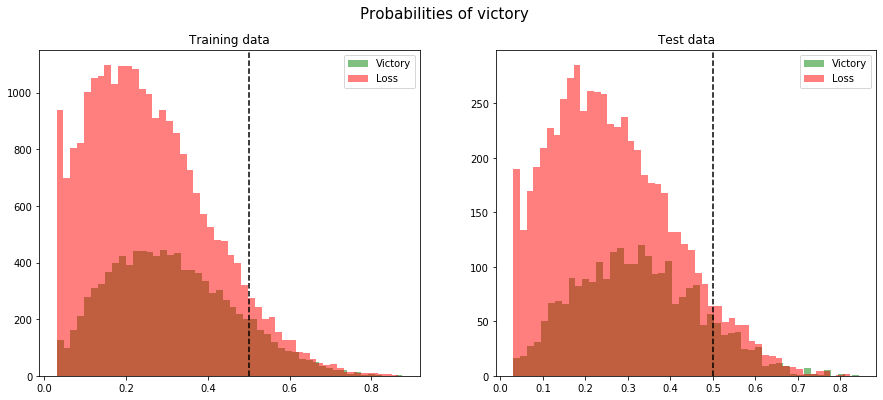

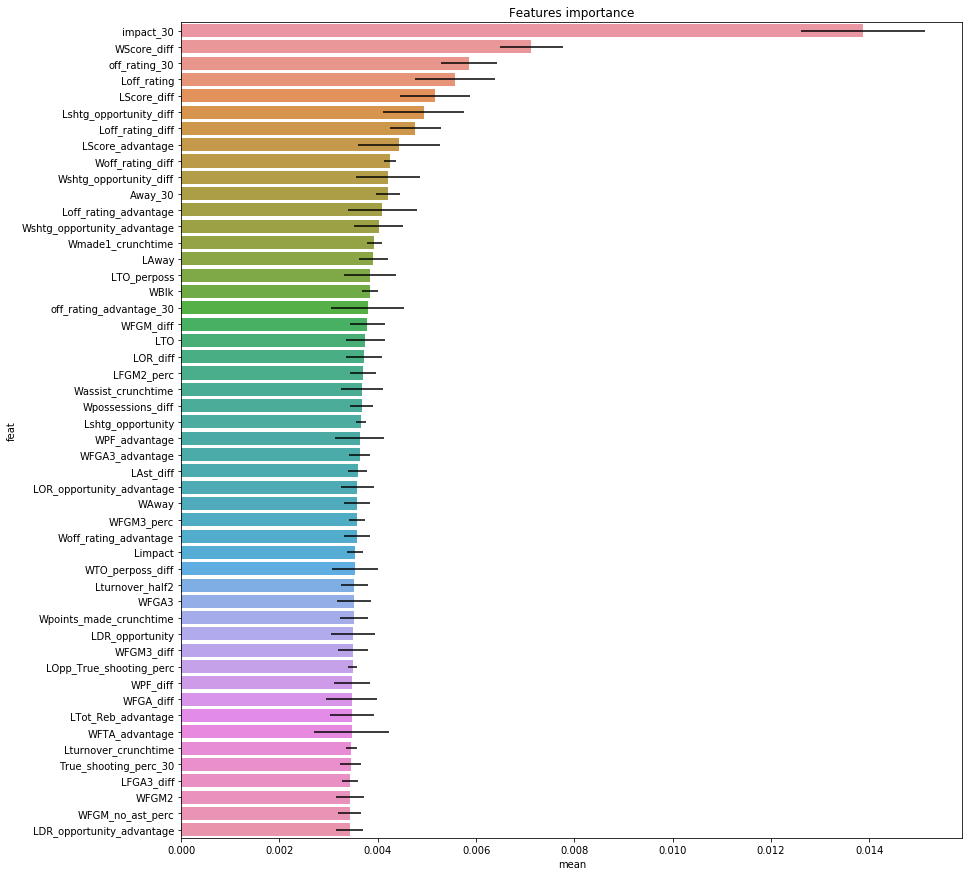

In [45]:
pipe = Pipeline([('scl', df_p.df_imputer())] + 
                [('xgb', XGBClassifier(objective='binary:logistic', 
                                       subsample=0.8,
                                       n_jobs=5, 
                                       max_depth=5, 
                                       learning_rate=0.1, 
                                       n_estimators=500))])

df_train = proc_all[to_use]

fitted_log, oof_pred_log, test_pred_log, imp_coef_log, train_log, y_train_log, test_log, y_test_log = random_split(df_train, pipe, kfolds, 'competitive', predict_proba=True)

rp.report_victory(y_train_log, y_test_log, oof_pred_log, test_pred_log, probs=True, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_log.head(50).reset_index(), 
            xerr=imp_coef_log.head(50)['std'])
plt.title(f'Features importance')
plt.show()

In [46]:
complete = pd.merge(events_t, proc_all, on=['Season', 'DayNum', 'WTeamID', 'LTeamID', 'tourney', 'competitive'])

complete.head()

,Season,DayNum,WTeamID,WScore_x,LTeamID,LScore_x,WLoc,NumOT,WFGM_x,WFGA_x,WFGM3_x,WFGA3_x,WFTM_x,WFTA_x,WOR_x,WDR_x,WAst_x,WTO_x,WStl_x,WBlk_x,WPF_x,LFGM_x,LFGA_x,LFGM3_x,LFGA3_x,LFTM_x,LFTA_x,LOR_x,LDR_x,LAst_x,LTO_x,LStl_x,LBlk_x,LPF_x,Wtop_team_x,Wupset_x,WOT_win_x,WAway_x,WFG_perc,WFGM2_x,WFGA2_x,WFG2_perc,WFG3_perc,WFT_perc_x,WTot_Reb_x,WFGM_no_ast_x,WFGM_no_ast_perc_x,Wpossessions_x,Woff_rating_x,Wshtg_opportunity_x,WTO_perposs_x,WTrue_shooting_perc_x,LFG_perc,LFGM2_x,LFGA2_x,LFG2_perc,LFG3_perc,LFT_perc_x,LTot_Reb_x,LFGM_no_ast_x,LFGM_no_ast_perc_x,Lpossessions_x,Loff_rating_x,Lshtg_opportunity_x,LTO_perposs_x,LTrue_shooting_perc_x,Wdef_rating_x,Ldef_rating_x,Wopp_shtg_opportunity_x,Lopp_shtg_opportunity_x,Wopp_possessions_x,Lopp_possessions_x,Wopp_score_x,Lopp_score_x,Wopp_FTA_x,Wopp_FGA_x,Lopp_FTA_x,Lopp_FGA_x,Wimpact_x,Limpact_x,WDR_opportunity_x,LDR_opportunity_x,WOR_opportunity_x,LOR_opportunity_x,Score_diff,Score_advantage,FGM_diff,FGM_advantage,FGA_diff,FGA_advantage,FGM3_diff,FGM3_advantage,FGA3_diff,FGA3_advantage,FTM_diff,FTM_advantage,FTA_diff,FTA_advantage,OR_diff,OR_advantage,DR_diff,DR_advantage,Ast_diff,Ast_advantage,TO_diff,TO_advantage,Stl_diff,Stl_advantage,Blk_diff,Blk_advantage,PF_diff,PF_advantage,FGM2_diff,FGM2_advantage,FGA2_diff,FGA2_advantage,Tot_Reb_diff,Tot_Reb_advantage,FGM_no_ast_advantage,DR_opportunity_diff,DR_opportunity_advantage,OR_opportunity_diff,OR_opportunity_advantage,possessions_diff,possessions_advantage,off_rating_diff,off_rating_advantage,def_rating_advantage,shtg_opportunity_diff,shtg_opportunity_advantage,TO_perposs_diff,TO_perposs_advantage,impact_diff,impact_advantage,True_shooting_perc_diff,True_shooting_perc_advantage,tourney,game_lc_x,half2_lc_x,crunchtime_lc_x,Wpoints_made_half2_x,Lpoints_made_half2_x,Wpoints_made_crunchtime_x,Lpoints_made_crunchtime_x,Wmade1_half2_x,Lmade1_half2_x,Wmade2_half2_x,Lmade2_half2_x,Wmade3_half2_x,Lmade3_half2_x,...,LFGM_diff,LFGM_advantage,LFGA_diff,LFGA_advantage,LFGM3_diff,LFGM3_advantage,LFGA3_diff,LFGA3_advantage,LFTM_diff,LFTM_advantage,LFTA_diff,LFTA_advantage,LOR_diff,LOR_advantage,LDR_diff,LDR_advantage,LAst_diff,LAst_advantage,LTO_diff,LTO_advantage,LStl_diff,LStl_advantage,LBlk_diff,LBlk_advantage,LPF_diff,LPF_advantage,LFGM2_diff,LFGM2_advantage,LFGA2_diff,LFGA2_advantage,LTot_Reb_diff,LTot_Reb_advantage,LFGM_no_ast_diff,LFGM_no_ast_advantage,LDR_opportunity_diff,LDR_opportunity_advantage,LOR_opportunity_diff,LOR_opportunity_advantage,Lpossessions_diff,Lpossessions_advantage,Loff_rating_diff,Loff_rating_advantage,Ldef_rating_diff,Ldef_rating_advantage,Lshtg_opportunity_diff,Lshtg_opportunity_advantage,LTO_perposs_diff,LTO_perposs_advantage,Limpact_diff,Limpact_advantage,LTrue_shooting_perc_diff,LTrue_shooting_perc_advantage,LN_wins,LFGM_perc,LFGM2_perc,LFGM3_perc,LFT_perc_y,LFGM_no_ast_perc_y,LTrue_shooting_perc_y,LOpp_True_shooting_perc,game_lc_30,half2_lc_30,crunchtime_lc_30,Score_30,FGM_30,FGA_30,FGM3_30,FGA3_30,FTM_30,FTA_30,OR_30,DR_30,Ast_30,TO_30,Stl_30,Blk_30,PF_30,OT_win_30,Away_30,FGM2_30,FGA2_30,Tot_Reb_30,FGM_no_ast_30,possessions_30,off_rating_30,shtg_opportunity_30,TO_perposs_30,def_rating_30,opp_shtg_opportunity_30,opp_possessions_30,opp_score_30,opp_FTA_30,opp_FGA_30,impact_30,DR_opportunity_30,OR_opportunity_30,points_made_half2_30,points_made_crunchtime_30,made1_half2_30,made2_half2_30,made3_half2_30,reb_half2_30,turnover_half2_30,assist_half2_30,steal_half2_30,block_half2_30,made1_crunchtime_30,made2_crunchtime_30,made3_crunchtime_30,reb_crunchtime_30,turnover_crunchtime_30,assist_crunchtime_30,steal_crunchtime_30,block_crunchtime_30,Score_advantage_30,FGM_advantage_30,FGA_advantage_30,FGM3_advantage_30,FGA3_advantage_30,FTM_advantage_30,FTA_advantage_30,OR_advantage_30,DR_advantage_30,Ast_advantage_30,TO_advantage_30,Stl_advantage_30,Blk_advantage_30,PF_advantage_30,FGM2_advantage_30,FGA2_advantage_30,Tot_Reb_advantage_30,FGM_no_ast_advantage_30,DR_opportunity_advantage_30,OR_opportunity_advantage_30,possessio

Accuracy train: 		 0.7738
Accuracy test: 			 0.7735
AUC ROC train: 			 0.6833
AUC ROC test: 			 0.6836
Logloss train: 			 0.4534
Logloss test: 			 0.4455
Unsure train: 			 14.0594%
Unsure test: 			 15.1019%


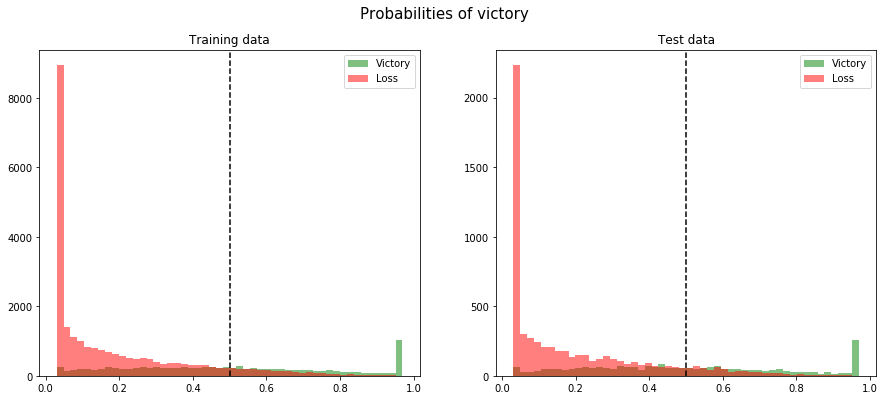

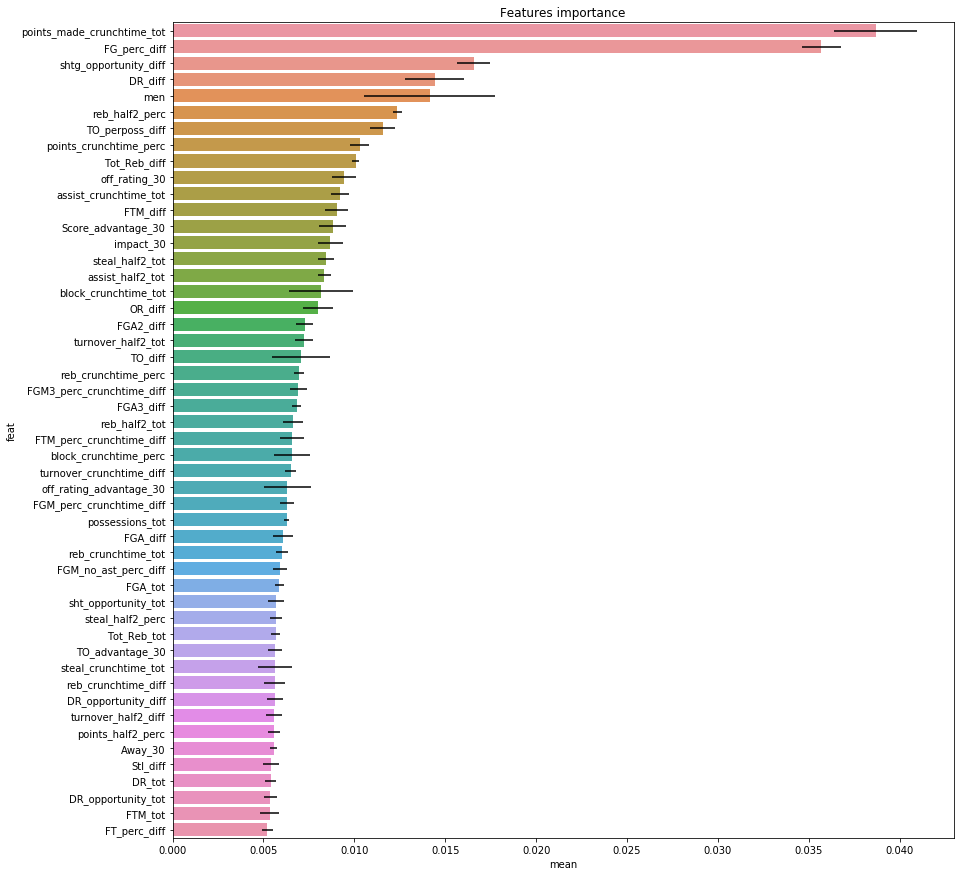

In [47]:
to_use = ['men'] + using + clean_set

pipe = Pipeline([('scl', df_p.df_imputer())] + 
                [('xgb', XGBClassifier(objective='binary:logistic', 
                                       subsample=0.8,
                                       n_jobs=5, 
                                       max_depth=5, 
                                       learning_rate=0.1, 
                                       n_estimators=700))])

df_train = complete[to_use]

fitted_log, oof_pred_log, test_pred_log, imp_coef_log, train_log, y_train_log, test_log, y_test_log = random_split(df_train, pipe, kfolds, 'competitive', predict_proba=True)

rp.report_victory(y_train_log, y_test_log, oof_pred_log, test_pred_log, probs=True, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_log.head(50).reset_index(), 
            xerr=imp_coef_log.head(50)['std'])
plt.title(f'Features importance')
plt.show()